# Forecasting Pharmaceutical Stock Price - USD to IDR Exchange Rate using a Hybrid Model VAR - LSTM

<div class="alert-success">
Nama :Dina Merlia Efendi
</div>

<div class="alert-danger">
Github : https://github.com/dinamerlia
</div>

## **VAR**

### **Membangkitkan Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import random
import warnings
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import tensorflow.keras as keras

from numpy import array
from sklearn.metrics import *
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import ConvLSTM2D
from keras.layers import Activation
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras import layers
from tensorflow.keras import regularizers
from timeit import default_timer as timer

plt.style.use('fivethirtyeight')
warnings.filterwarnings("ignore")

In [ ]:
%cd /content/drive/MyDrive/SATRIADATA2023/SEC/

/content/drive/MyDrive/SATRIADATA2023/SEC


In [ ]:
data = pd.read_excel("/content/drive/MyDrive/SATRIADATA2023/SEC/SMGR Dollar.xlsx", parse_dates = True, index_col = 0)
data

Close  Kurs Dollar
Date                           
2010-01-04  7600.0         9075
2010-01-06  7800.0         9210
2010-01-07  7700.0         9094
2010-01-11  7750.0         8921
2010-01-12  7750.0         9032
...            ...          ...
2023-06-23  6125.0        14918
2023-06-26  6150.0        14998
2023-06-27  6075.0        15026
2023-07-03  6075.0        15301
2023-07-06  6250.0        14839

[2895 rows x 2 columns]

## **Preprocessing**

### **Cek Missing Value**

In [ ]:
data.isnull().sum()

Close          0
Kurs Dollar    0
dtype: int64

### **Cek Korelasi**

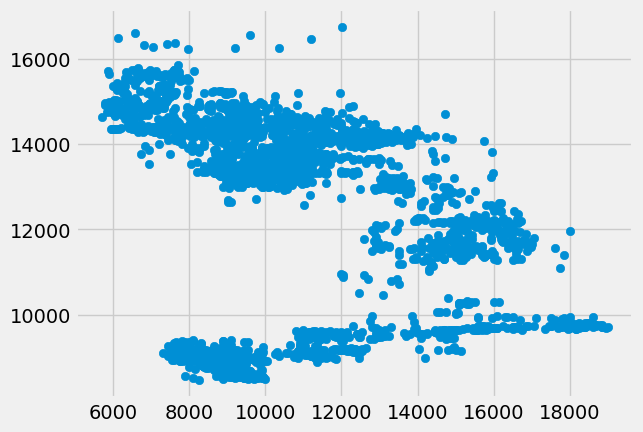

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [ ]:
plt.scatter(data["Close"], data["Kurs Dollar"])
plt.show()
np.corrcoef(data, rowvar = True)

In [ ]:
# Menghitung matriks korelasi
correlation_matrix = np.corrcoef(data["Close"], data["Kurs Dollar"])
print("Matriks Korelasi:")
print(correlation_matrix)

Matriks Korelasi:
[[ 1.         -0.30180759]
 [-0.30180759  1.        ]]


### **Plot Data Awal**

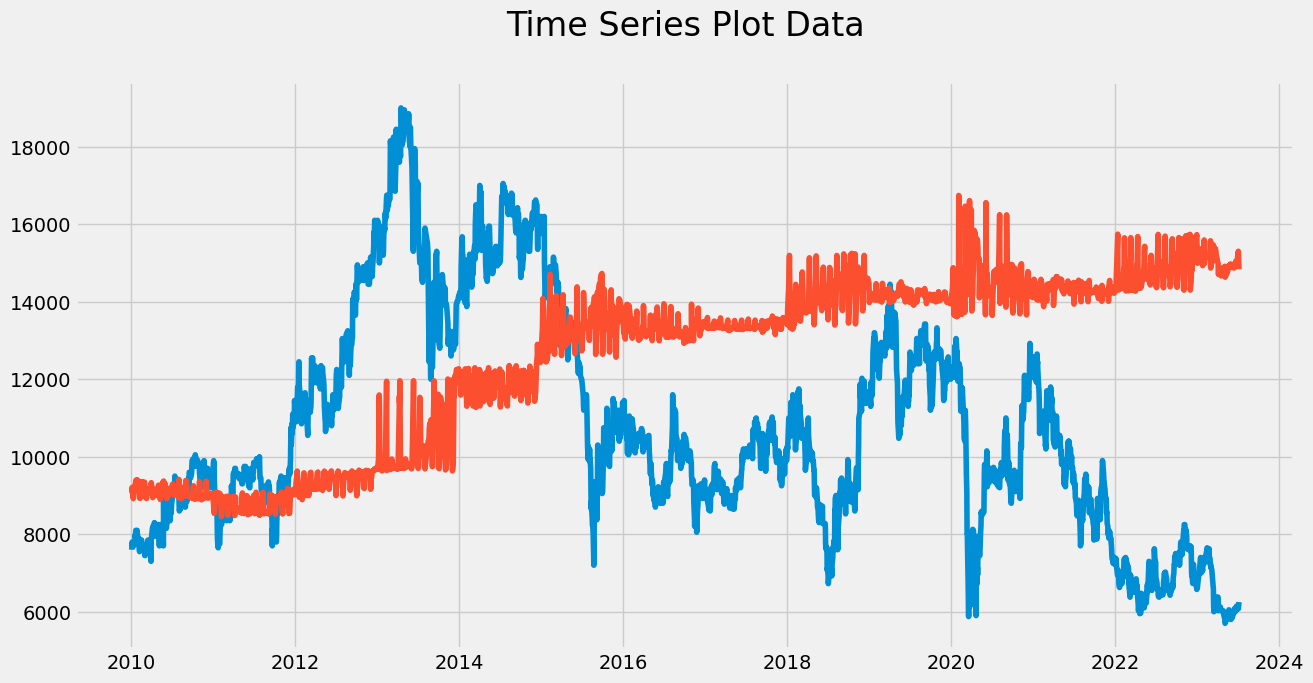

In [ ]:
plt.figure(figsize = (14,7))
plt.title('Time Series Plot Data\n', fontsize = 24)
plt.plot(data)
plt.show()

### **Cek stasioner data**

In [ ]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluatidatabaruon metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [ ]:
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [ ]:
data.columns

Index(['Close', 'Kurs Dollar'], dtype='object')

In [ ]:
for name, column in data.iteritems():
    Augmented_Dickey_Fuller_Test_func(data[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Close
Test Statistic                   -1.878739
p-value                           0.342128
No Lags Used                     13.000000
Number of Observations Used    2881.000000
Critical Value (1%)              -3.432622
Critical Value (5%)              -2.862544
Critical Value (10%)             -2.567304
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


Results of Dickey-Fuller Test for column: Kurs Dollar
Test Statistic                   -1.056520
p-value                           0.732096
No Lags Used                     21.000000
Number of Observations Used    2873.000000
Critical Value (1%)              -3.432628
Critical Value (5%)              -2.862547
Critical Value (10%)             -2.567306
dtype: float64
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary




### **Differencing Data**

In [ ]:
data_diff = data.diff().dropna()

In [ ]:
data_diff

Close  Kurs Dollar
Date                          
2010-01-06  200.0        135.0
2010-01-07 -100.0       -116.0
2010-01-11   50.0       -173.0
2010-01-12    0.0        111.0
2010-01-13  -50.0        148.0
...           ...          ...
2023-06-23  100.0        -64.0
2023-06-26   25.0         80.0
2023-06-27  -75.0         28.0
2023-07-03    0.0        275.0
2023-07-06  175.0       -462.0

[2894 rows x 2 columns]

In [ ]:
for name, column in data_diff.iteritems():
    Augmented_Dickey_Fuller_Test_func(data_diff[name],name)
    print('\n')

Results of Dickey-Fuller Test for column: Close
Test Statistic                -1.609978e+01
p-value                        5.146391e-29
No Lags Used                   1.300000e+01
Number of Observations Used    2.880000e+03
Critical Value (1%)           -3.432623e+00
Critical Value (5%)           -2.862544e+00
Critical Value (10%)          -2.567305e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary


Results of Dickey-Fuller Test for column: Kurs Dollar
Test Statistic                -1.704754e+01
p-value                        8.113638e-30
No Lags Used                   2.000000e+01
Number of Observations Used    2.873000e+03
Critical Value (1%)           -3.432628e+00
Critical Value (5%)           -2.862547e+00
Critical Value (10%)          -2.567306e+00
dtype: float64
Conclusion:====>
Reject the null hypothesis
Data is stationary




###**Plot Data Differencing**

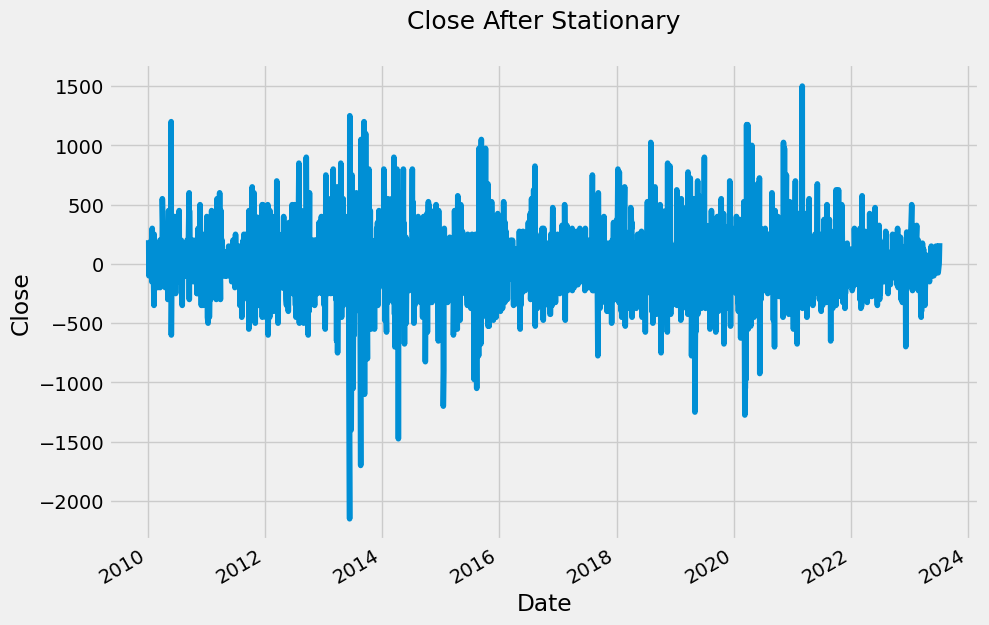

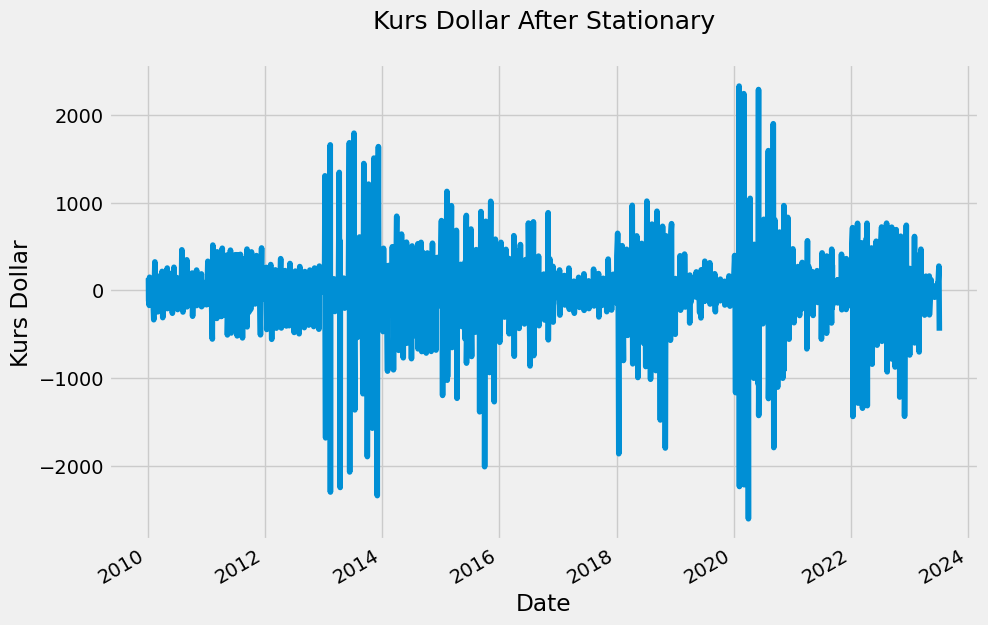

In [ ]:
for feature in data_diff:
    data_diff[str(feature)].plot(figsize = (10, 7))
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.title(f"{str(feature)} After Stationary\n", fontsize = 18)
    plt.show()

###**Uji Kausalitas Granger**

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=5
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(data_diff, variables = data_diff.columns)

Close_x  Kurs Dollar_x
Close_y         1.0000         0.0001
Kurs Dollar_y   0.0166         1.0000

###**Tes Kointegrasi**

In [ ]:
def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
cointegration_test(data_diff)

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Close  >  1442.04   > 12.3212   =>   True
Kurs Dollar >  545.52    > 4.1296    =>   True


In [ ]:
data_diff

Close  Kurs Dollar
Date                          
2010-01-06  200.0        135.0
2010-01-07 -100.0       -116.0
2010-01-11   50.0       -173.0
2010-01-12    0.0        111.0
2010-01-13  -50.0        148.0
...           ...          ...
2023-06-23  100.0        -64.0
2023-06-26   25.0         80.0
2023-06-27  -75.0         28.0
2023-07-03    0.0        275.0
2023-07-06  175.0       -462.0

[2894 rows x 2 columns]

##**Model Terbaik**

### **Plot PACF Close**

In [ ]:
Close = data_diff['Close']

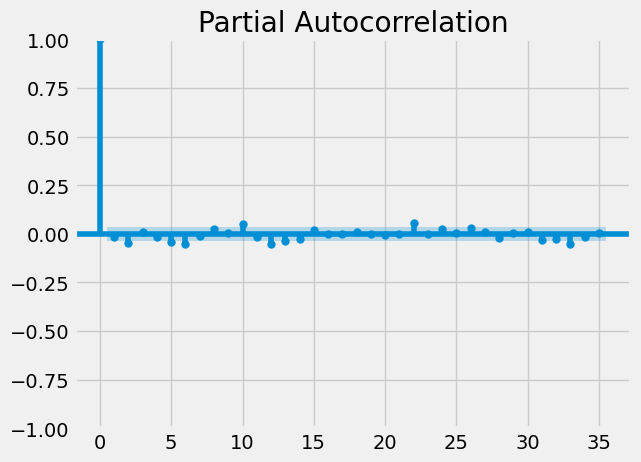

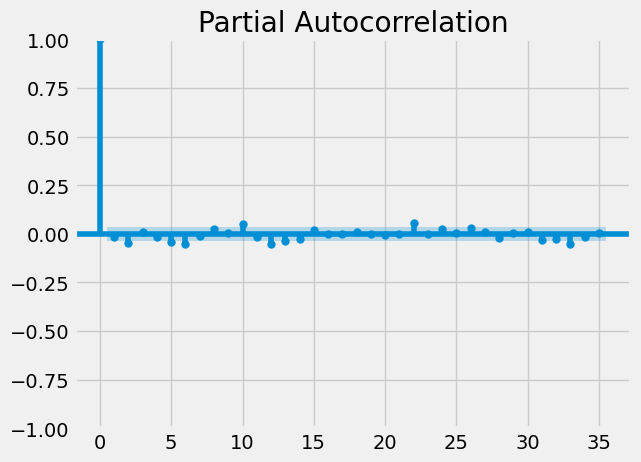

In [ ]:
plot_pacf(Close)

### **Plot ACF dan PACF Kurs Dollar**

In [ ]:
Kurs_Dollar = data_diff['Kurs Dollar']

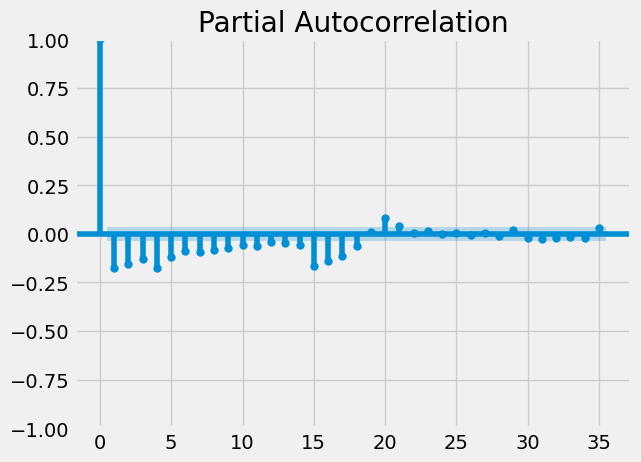

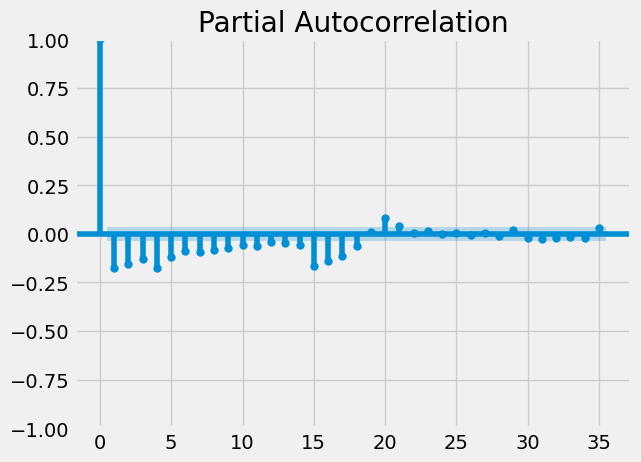

In [ ]:
plot_pacf(Kurs_Dollar)

### **Trial and Error**

In [ ]:
#Initiate VAR model
model = VAR(endog = data_diff)
res = model.select_order(15)
res.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

###**Prediksi**

In [ ]:
#Fit to a VAR model
model_fit = model.fit(maxlags=6)
#Print a summary of the model results
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Aug, 2023
Time:                     10:21:06
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    22.5049
Nobs:                     2888.00    HQIC:                   22.4705
Log likelihood:          -40589.3    FPE:                5.62890e+09
AIC:                      22.4512    Det(Omega_mle):     5.57857e+09
--------------------------------------------------------------------
Results for equation Close
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.654339         4.951088           -0.132           0.895
L1.Close              -0.015225         0.018647           -0.817           0.414
L1.Kurs Dollar         0.017358         0.017593        

In [ ]:
# Get the lag order
lag_order = model_fit.k_ar

In [ ]:
# Input data for forecasting
input_data = data_diff.values[:]

In [ ]:
input_data

array([[ 200.,  135.],
       [-100., -116.],
       [  50., -173.],
       ...,
       [ -75.,   28.],
       [   0.,  275.],
       [ 175., -462.]])

In [ ]:
nobs = 2888

In [ ]:
prediction = pd.DataFrame( model_fit.forecast(y=input_data, steps=nobs), index=data_diff.index[-nobs:])
prediction.columns = ['Prediction Close', 'Prediction Kurs Dollar']
prediction.index.names = ['Date']
prediction

Prediction Close  Prediction Kurs Dollar
Date                                                
2010-01-15        -35.394773               47.768564
2010-01-18         19.850256               32.191983
2010-01-19          1.394376                1.923458
2010-01-20          3.701679               47.780258
2010-01-21        -19.135203               17.796871
...                      ...                     ...
2023-06-23         -0.526504                2.022723
2023-06-26         -0.526504                2.022723
2023-06-27         -0.526504                2.022723
2023-07-03         -0.526504                2.022723
2023-07-06         -0.526504                2.022723

[2888 rows x 2 columns]

### **Denormalization**

In [ ]:
prediction['Prediction Close'] = data['Close'].shift(1) + prediction['Prediction Close']
prediction['Prediction Kurs Dollar'] = data['Kurs Dollar'].shift(1) + prediction['Prediction Kurs Dollar']
prediction

Prediction Close  Prediction Kurs Dollar
Date                                                
2010-01-15       7714.605227             9197.768564
2010-01-18       7819.850256             9237.191983
2010-01-19       7751.394376             9231.923458
2010-01-20       7853.701679             9272.780258
2010-01-21       7980.864797             9292.796871
...                      ...                     ...
2023-06-23       6024.473496            14984.022723
2023-06-26       6124.473496            14920.022723
2023-06-27       6149.473496            15000.022723
2023-07-03       6074.473496            15028.022723
2023-07-06       6074.473496            15303.022723

[2888 rows x 2 columns]

In [ ]:
data_loc = data.iloc[7:]
print(data_loc)

             Close  Kurs Dollar
Date                           
2010-01-15  7800.0         9205
2010-01-18  7750.0         9230
2010-01-19  7850.0         9225
2010-01-20  8000.0         9275
2010-01-21  7900.0         9319
...            ...          ...
2023-06-23  6125.0        14918
2023-06-26  6150.0        14998
2023-06-27  6075.0        15026
2023-07-03  6075.0        15301
2023-07-06  6250.0        14839

[2888 rows x 2 columns]


### **Gabungan Prediksi dan data aktual**

In [ ]:
gabungan = pd.merge(prediction, data_loc, left_index = True, right_index = True)
gabungan

Prediction Close  Prediction Kurs Dollar   Close  Kurs Dollar
Date                                                                     
2010-01-15       7714.605227             9197.768564  7800.0         9205
2010-01-18       7819.850256             9237.191983  7750.0         9230
2010-01-19       7751.394376             9231.923458  7850.0         9225
2010-01-20       7853.701679             9272.780258  8000.0         9275
2010-01-21       7980.864797             9292.796871  7900.0         9319
...                      ...                     ...     ...          ...
2023-06-23       6024.473496            14984.022723  6125.0        14918
2023-06-26       6124.473496            14920.022723  6150.0        14998
2023-06-27       6149.473496            15000.022723  6075.0        15026
2023-07-03       6074.473496            15028.022723  6075.0        15301
2023-07-06       6074.473496            15303.022723  6250.0        14839

[2888 rows x 4 columns]

### **Plot Data Aktual dan Prediksi**

Text(0, 0.5, 'Rupiah\n')

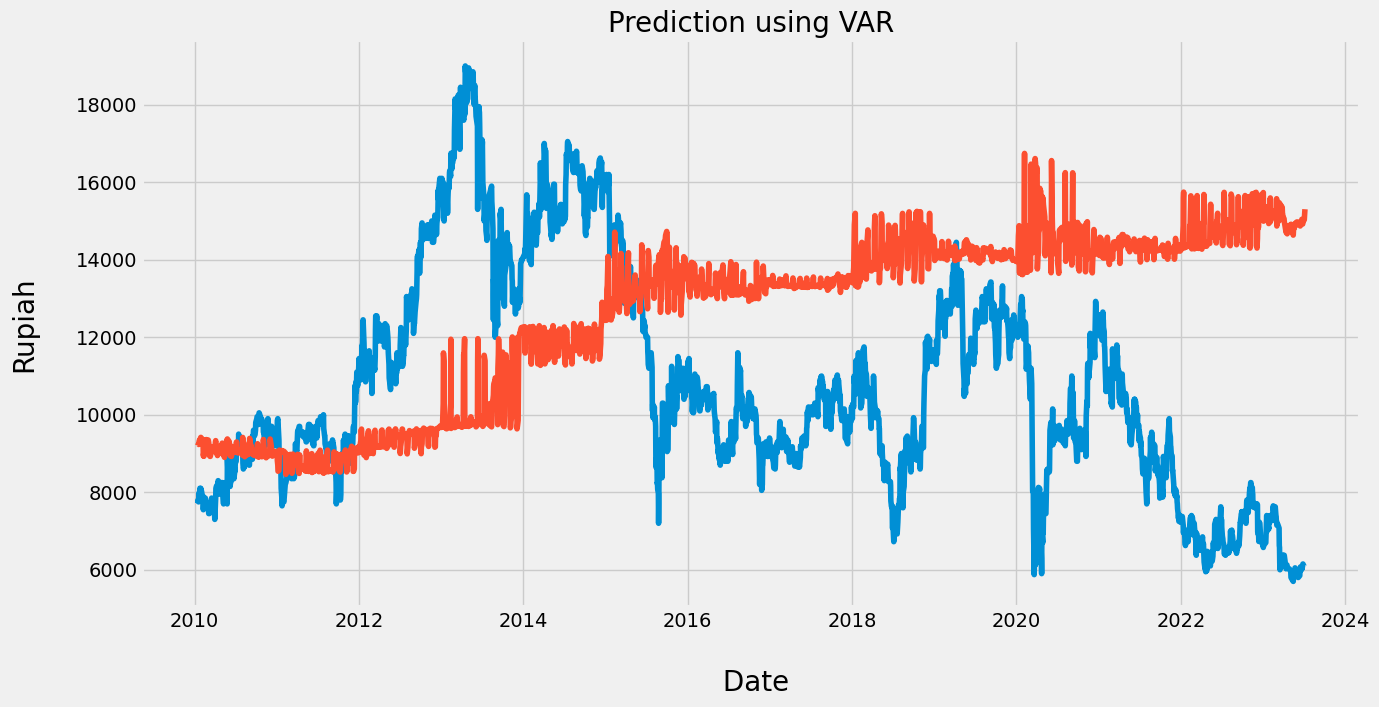

In [ ]:
plt.figure(figsize = (14,7))
plt.plot(prediction)
plt.title('Prediction using VAR', fontsize = 20)
plt.xlabel('\n Date', fontsize = 20)
plt.ylabel('Rupiah\n', fontsize = 20)

Text(0.5, 1.0, ' Actual Data vs Prediction\n')

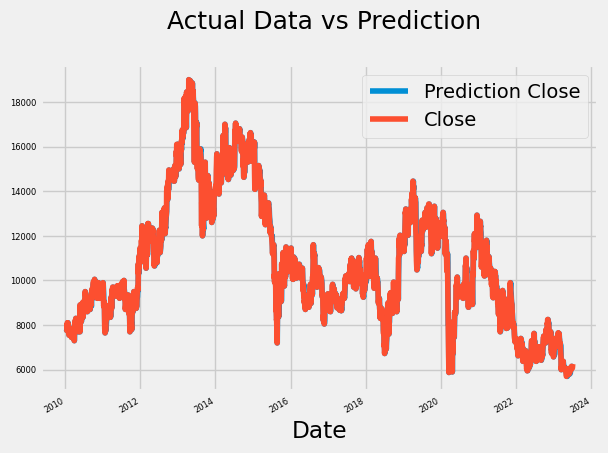

In [ ]:
prediction['Prediction Close'].plot(legend = True, fontsize = 6)
data_loc['Close'].plot(legend = True, fontsize = 6)
plt.title(" Actual Data vs Prediction\n", fontsize = 18)

Text(0, 0.5, 'Rupiah\n')

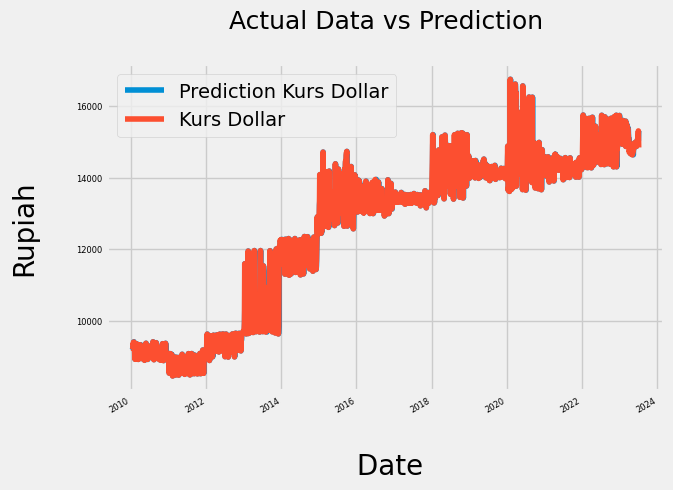

In [ ]:
prediction['Prediction Kurs Dollar'].plot(legend = True, fontsize = 6)
data_loc['Kurs Dollar'].plot(legend = True, fontsize = 6)
plt.title("Actual Data vs Prediction\n", fontsize = 18)
plt.xlabel('\n Date', fontsize = 20)
plt.ylabel('Rupiah\n', fontsize = 20)

### **Evaluasi Model**

In [ ]:
mse = mean_squared_error(data_loc, prediction)
rmse = mse**(1/2)
mape = mean_absolute_percentage_error(data_loc, prediction)
mae = mean_absolute_error(data_loc, prediction)
akurasi = 100 - mape
print("MSE VAR Model is %.2f" % mse)
print("RMSE VAR Model is %.2f" % rmse)
print("MAPE VAR Model is %.4f" % mape)
print("MAE VAR Model is %.2f" % mae)
print("Accuracy VAR Model is %.4f" % akurasi)

MSE VAR Model is 80564.12
RMSE VAR Model is 283.84
MAPE VAR Model is 0.0142
MAE VAR Model is 160.16
Accuracy VAR Model is 99.9858


### **Nilai Residual**

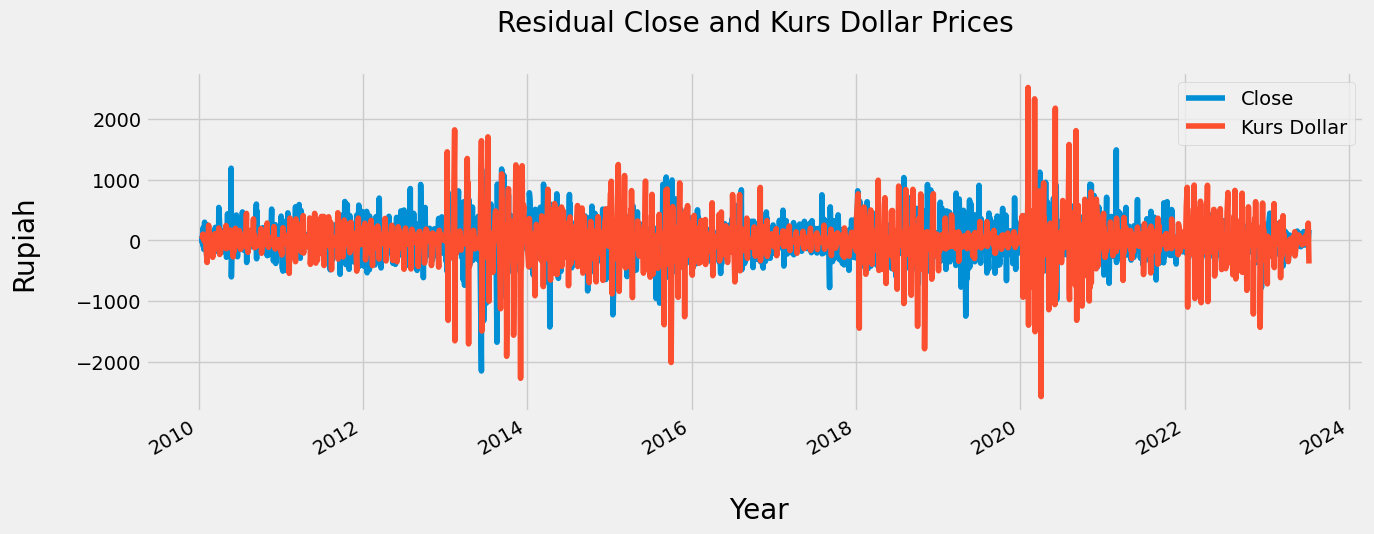

In [ ]:
residual = pd.DataFrame(model_fit.resid)
residual.plot(figsize = (14,5))
plt.xlabel('\n Year', fontsize = 20)
plt.ylabel('Rupiah\n', fontsize = 20)
plt.title('Residual Close and Kurs Dollar Prices\n')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
residual

Close  Kurs Dollar
Date                               
2010-01-15   66.921779    70.390527
2010-01-18  -45.891920    47.730930
2010-01-19  103.969083    40.321869
2010-01-20  142.864737    95.611971
2010-01-21  -93.437225    85.895414
...                ...          ...
2023-06-23  103.293593   -47.199322
2023-06-26   20.225733    72.264123
2023-06-27  -74.519237    37.859885
2023-07-03    4.504500   283.357758
2023-07-06  171.490311  -382.783256

[2888 rows x 2 columns]

##**Peramalan VAR**

In [ ]:
# Number of observations to forecast
nobs = 30

# Input data for forecasting (use the last 'lag_order' rows of data_diff as initial input)
input_data = data_diff[-lag_order:].values

# Forecast the next 'nobs' observations
forecast = model_fit.forecast(y=input_data, steps=nobs)

# Assuming 'updated_data' is the DataFrame containing the updated data
forecast_index = data_update.index[-nobs:]

# Create a DataFrame for the forecasted values
forecast30 = pd.DataFrame(forecast, index=forecast_index, columns=data_diff.columns)
forecast30.columns = ['Prediction Close', 'Prediction Kurs Dollar']
forecast30.index.names = ['Date']
forecast30


Prediction Close  Prediction Kurs Dollar
Date                                                
2023-07-07        -35.394773               47.768564
2023-07-10         19.850256               32.191983
2023-07-11          1.394376                1.923458
2023-07-12          3.701679               47.780258
2023-07-13        -19.135203               17.796871
2023-07-14        -13.784823                7.675394
2023-07-17          2.513820              -19.679225
2023-07-18         -1.061957               -9.781103
2023-07-20          2.117659               -0.051202
2023-07-21          1.929413                2.243912
2023-07-24          0.974977                8.062186
2023-07-25         -0.836393                6.382884
2023-07-26         -1.709371                3.117898
2023-07-27         -1.013632                0.629813
2023-07-28         -0.747706               -0.058890
2023-07-31         -0.387079                0.816638
2023-08-01         -0.238521                1.735312
2023-08-02         -0.336007                2.623724
2023-08-03         -0.493787                2.788512
2023-08-04         -0.625773                2.420444
2023-08-07         -0.627509                2.018152
2023-08-08         -0.579305                1.771755
2023-08-09         -0.521873                1.770617
2023-08-10         -0.486610                1.900566
2023-08-11         -0.489738                2.048497
2023-08-14         -0.510652                2.123756
2023-08-15         -0.532593                2.109033
2023-08-16         -0.542142                2.054644
2023-08-18         -0.539171                2.004682
2023-08-21         -0.530662                1.985026

In [ ]:
# Denormalize the forecasted values
denormalized_prediction = forecast30.copy()
denormalized_prediction['Prediction Close'] = data['Close'].iloc[-1] + denormalized_prediction['Prediction Close'].cumsum()
denormalized_prediction['Prediction Kurs Dollar'] = data['Kurs Dollar'].iloc[-1] + denormalized_prediction['Prediction Kurs Dollar'].cumsum()
denormalized_prediction

Prediction Close  Prediction Kurs Dollar
Date                                                
2023-07-07       6214.605227            14886.768564
2023-07-10       6234.455483            14918.960547
2023-07-11       6235.849858            14920.884005
2023-07-12       6239.551537            14968.664263
2023-07-13       6220.416334            14986.461134
2023-07-14       6206.631512            14994.136527
2023-07-17       6209.145332            14974.457302
2023-07-18       6208.083375            14964.676198
2023-07-20       6210.201034            14964.624996
2023-07-21       6212.130447            14966.868908
2023-07-24       6213.105424            14974.931094
2023-07-25       6212.269031            14981.313978
2023-07-26       6210.559659            14984.431876
2023-07-27       6209.546028            14985.061689
2023-07-28       6208.798321            14985.002800
2023-07-31       6208.411243            14985.819437
2023-08-01       6208.172722            14987.554750
2023-08-02       6207.836715            14990.178473
2023-08-03       6207.342927            14992.966985
2023-08-04       6206.717155            14995.387430
2023-08-07       6206.089646            14997.405582
2023-08-08       6205.510341            14999.177337
2023-08-09       6204.988468            15000.947953
2023-08-10       6204.501857            15002.848520
2023-08-11       6204.012119            15004.897017
2023-08-14       6203.501467            15007.020773
2023-08-15       6202.968874            15009.129806
2023-08-16       6202.426731            15011.184450
2023-08-18       6201.887560            15013.189132
2023-08-21       6201.356898            15015.174157

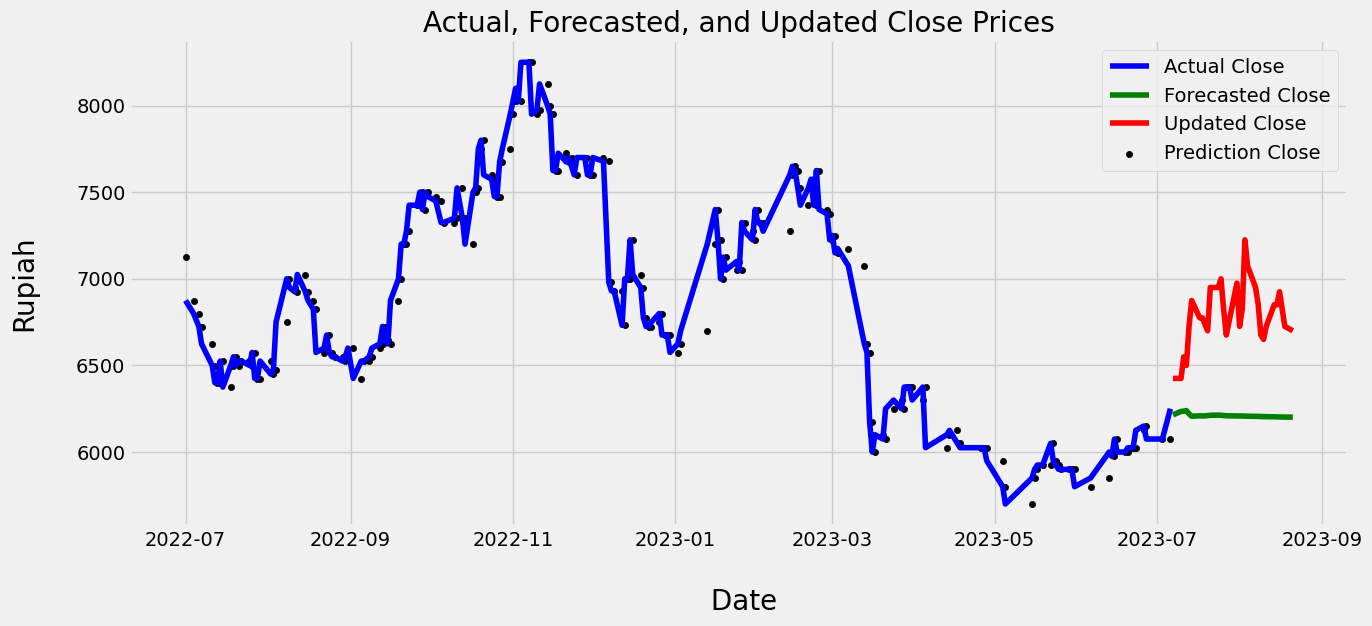

In [ ]:
# Plot actual data, forecasted data, and updated data
plt.figure(figsize=(14, 6))
plt.plot(data.index[-200:], data['Close'].iloc[-200:], label='Actual Close', color='blue')
plt.plot(denormalized_prediction.index, denormalized_prediction['Prediction Close'], label='Forecasted Close', color='green')
plt.plot(data_update.index, data_update['Close'], label='Updated Close', color='red')
plt.scatter(prediction.index[-200:], prediction['Prediction Close'].iloc[-200:], label='Prediction Close', color = 'black', marker='o', s=20)
plt.xlabel('\n Date', fontsize = 20)
plt.ylabel('Rupiah\n', fontsize = 20)
plt.title('Actual, Forecasted, and Updated Close Prices')
plt.legend()
plt.grid(True)
plt.show()

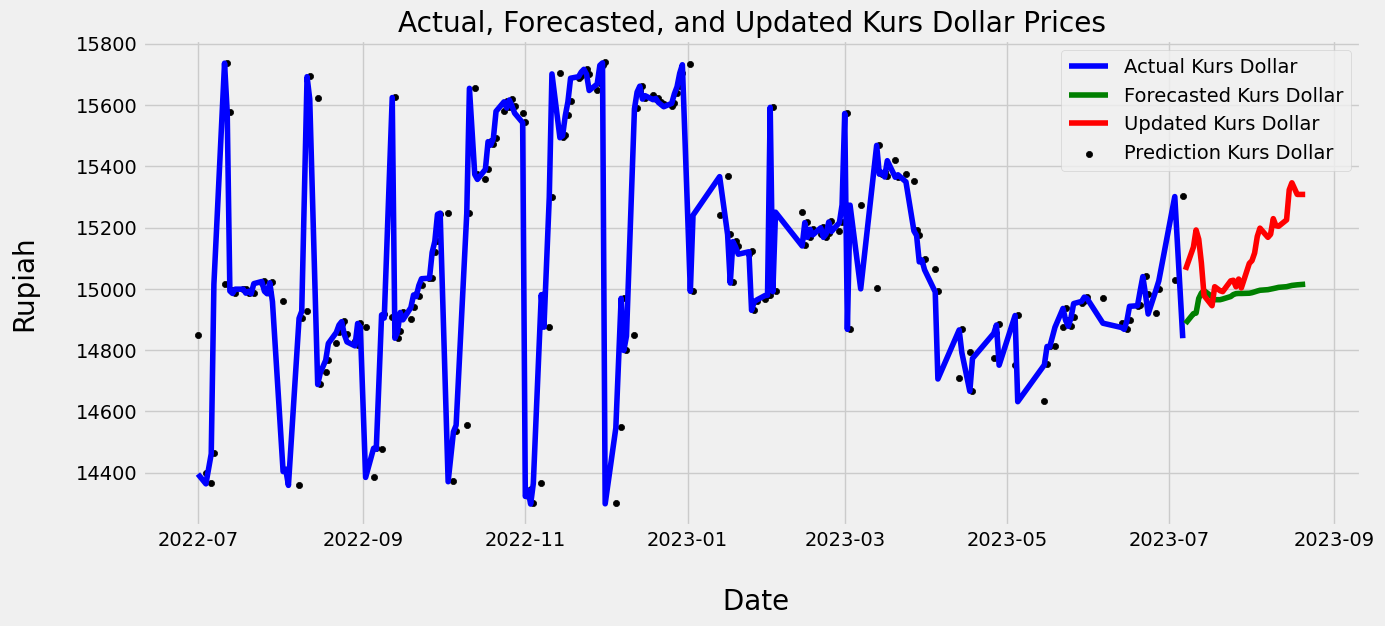

In [ ]:
# Plot actual data, forecasted data, and updated data
plt.figure(figsize=(14, 6))
plt.plot(data.index[-200:], data['Kurs Dollar'].iloc[-200:], label='Actual Kurs Dollar', color='blue')
plt.plot(denormalized_prediction.index, denormalized_prediction['Prediction Kurs Dollar'], label='Forecasted Kurs Dollar', color='green')
plt.plot(data_update.index, data_update['Kurs Dollar'], label='Updated Kurs Dollar', color='red')
plt.scatter(prediction.index[-200:], prediction['Prediction Kurs Dollar'].iloc[-200:], label='Prediction Kurs Dollar', color='black', marker='o', s=20)
plt.xlabel('\n Date', fontsize = 20)
plt.ylabel('Rupiah\n', fontsize = 20)
plt.title('Actual, Forecasted, and Updated Kurs Dollar Prices')
plt.legend()
plt.grid(True)
plt.show()

##**LSTM DATA AWAL**

### **Splitting Data 80:20**

In [ ]:
training_portion = .8

#train size
train_size = int(len(data) * training_portion)

training_data = data[0: train_size]
testing_data = data[train_size:]

print("train_data: ", training_data.shape)
print("test_data: ", testing_data.shape)

train_data:  (2316, 2)
test_data:  (579, 2)


### **Scaling Data Prediksi**

In [ ]:
# MinMax Scaler
scaler = MinMaxScaler()

# Data Train
train_scale = pd.DataFrame(scaler.fit_transform(training_data), columns = ['Close', 'Kurs Dollar'])
test_scale = pd.DataFrame(scaler.fit_transform(testing_data), columns = ['Close', 'Kurs Dollar'])

In [ ]:
train_data = np.array(train_scale)
test_data = np.array(test_scale)

In [ ]:
def create_dataset(dataset,time_steps):
    dataX = []
    dataY = []
    for i in range(time_steps, len(dataset)):
            dataX.append(dataset[i - time_steps:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0:dataset.shape[1]])
    return np.array(dataX),np.array(dataY)

In [ ]:
time_steps = 5
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

### **Hypertuning menggunakan Grid Search**

In [ ]:
def create_model(LSTM_unit, dropout):
  # create model
  model = Sequential()
  model.add(LSTM(units = LSTM_unit, input_shape = (time_steps, 2), activation = 'tanh' ))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))
  model.add(Dense(units = LSTM_unit, activation = 'sigmoid'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))
  model.add(Dense(units = LSTM_unit, activation = 'sigmoid'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))
  model.add(Dense(2, activation = 'sigmoid'))

  # compile model
  model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

  return model

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0)

#create model
model = KerasRegressor(build_fn = create_model, validation_split = 0.25, callbacks = [es], epochs = 100, verbose = 1)
LSTM_unit = [16, 32, 64]
batch_size = [16, 32, 64]
dropout = [0.1]
param_grid = dict(batch_size = batch_size, LSTM_unit = LSTM_unit, dropout = dropout)

In [ ]:
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = 3, cv = 5, verbose = 1)

In [ ]:
%%time
grid_result= grid.fit(X_train, y_train, validation_split = 0.25, verbose = 1, callbacks = [es])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/100
109/109 [==============================] - 5s 14ms/step - loss: 0.0303 - val_loss: 0.1133
Epoch 2/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0146 - val_loss: 0.0993
Epoch 3/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0121 - val_loss: 0.0711
Epoch 4/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0107 - val_loss: 0.0368
Epoch 5/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0103 - val_loss: 0.0086
Epoch 6/100
109/109 [==============================] - 1s 8ms/step - loss: 0.0094 - val_loss: 0.0029
Epoch 7/100
109/109 [==============================] - 1s 12ms/step - loss: 0.0083 - val_loss: 0.0030
Epoch 8/100
109/109 [==============================] - 1s 11ms/step - loss: 0.0080 - val_loss: 0.0030
Epoch 9/100
109/109 [==============================] - 1s 12ms/step - loss: 0.0081 - val_loss: 0.0029
Epoch 10/100
109/109 [=====

In [ ]:
# melihat hasil parameter terbaik
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

# mengambil model terbaik
best_model = grid_result.best_estimator_.model

Best: -0.003382 using {'LSTM_unit': 32, 'batch_size': 16, 'dropout': 0.1}
-0.004217 (0.002252) with: {'LSTM_unit': 16, 'batch_size': 16, 'dropout': 0.1}
-0.003553 (0.001266) with: {'LSTM_unit': 16, 'batch_size': 32, 'dropout': 0.1}
-0.071978 (0.031349) with: {'LSTM_unit': 16, 'batch_size': 64, 'dropout': 0.1}
-0.003382 (0.001208) with: {'LSTM_unit': 32, 'batch_size': 16, 'dropout': 0.1}
-0.009400 (0.011606) with: {'LSTM_unit': 32, 'batch_size': 32, 'dropout': 0.1}
-0.075501 (0.023884) with: {'LSTM_unit': 32, 'batch_size': 64, 'dropout': 0.1}
-0.003528 (0.001701) with: {'LSTM_unit': 64, 'batch_size': 16, 'dropout': 0.1}
-0.010650 (0.016105) with: {'LSTM_unit': 64, 'batch_size': 32, 'dropout': 0.1}
-0.063778 (0.031448) with: {'LSTM_unit': 64, 'batch_size': 64, 'dropout': 0.1}


### **Membangun Model LSTM untuk Data Prediksi**

In [ ]:
seed = 123
np.random.seed(seed)

In [ ]:
# Build model
model = Sequential()
model.add(LSTM(units = 32, input_shape = (time_steps, 2), activation = 'tanh', recurrent_activation = 'sigmoid', return_sequences = False))
model.add(Dense(units = 32, activation = 'tanh'))
model.add(Dense(units = 16, activation = 'tanh'))
model.add(Dense(units = 8, activation = 'tanh'))
model.add(Dense(2, activation = 'sigmoid'))

# Compile model
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

In [ ]:
# Build model
model = Sequential()
model.add(LSTM(units = 32, input_shape = (time_steps, 2), activation = 'tanh' ))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units = 16, activation = 'sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(units = 8, activation = 'sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(2, activation = 'sigmoid'))

# Compile model
model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

In [ ]:
%%time
#Early Stopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0)

#Fit Model
history = model.fit(X_train, y_train, epochs = 100, batch_size = 16, verbose = 1, validation_data = (X_test, y_test), callbacks = [es])

Epoch 1/100
145/145 [==============================] - 2s 13ms/step - loss: 0.0067 - val_loss: 0.0089
Epoch 2/100
145/145 [==============================] - 1s 8ms/step - loss: 0.0064 - val_loss: 0.0092
Epoch 3/100
145/145 [==============================] - 1s 8ms/step - loss: 0.0065 - val_loss: 0.0086
Epoch 4/100
145/145 [==============================] - 1s 8ms/step - loss: 0.0061 - val_loss: 0.0090
Epoch 5/100
145/145 [==============================] - 3s 18ms/step - loss: 0.0064 - val_loss: 0.0086
Epoch 6/100
145/145 [==============================] - 3s 22ms/step - loss: 0.0059 - val_loss: 0.0085
Epoch 7/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0062 - val_loss: 0.0094
Epoch 8/100
145/145 [==============================] - 1s 8ms/step - loss: 0.0061 - val_loss: 0.0089
Epoch 9/100
145/145 [==============================] - 1s 8ms/step - loss: 0.0060 - val_loss: 0.0086
Epoch 10/100
145/145 [==============================] - 1s 8ms/step - loss: 0.0063 - va

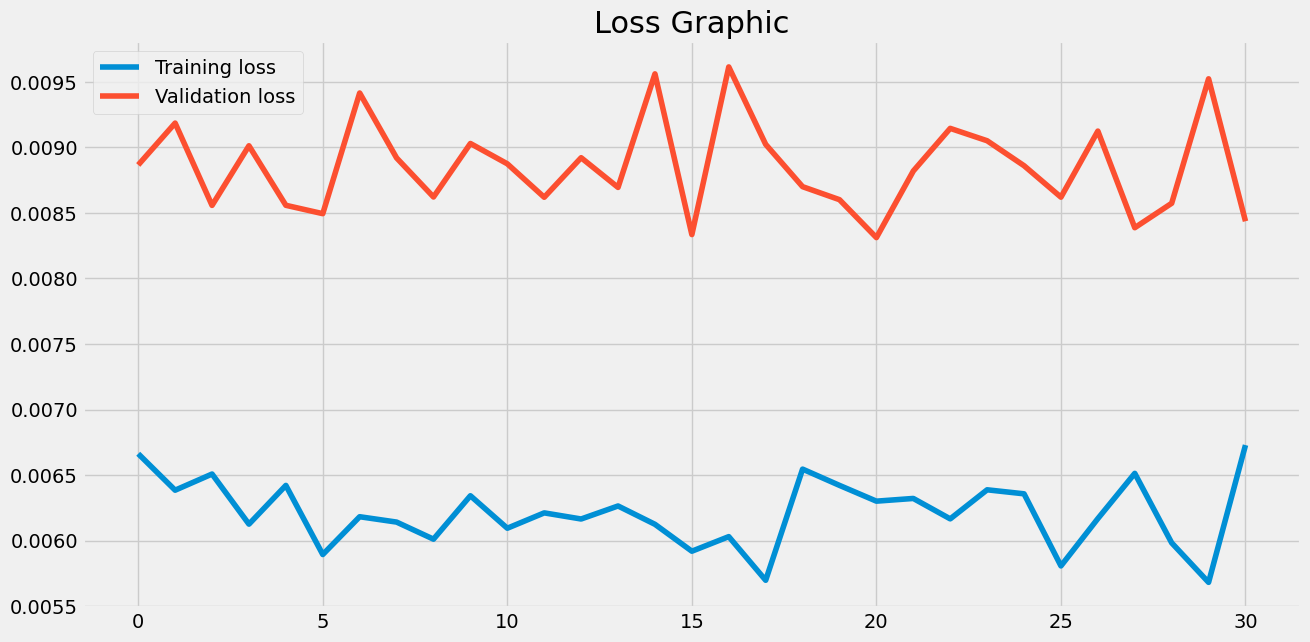

In [ ]:
plt.figure(figsize = (14, 7))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.title('Loss Graphic', fontsize = 22)
plt.legend()

In [ ]:
test_predict1 = model.predict(X_test)
test_predict1

18/18 [==============================] - 0s 3ms/step


array([[0.40403917, 0.64766026],
       [0.45386484, 0.65009063],
       [0.44870898, 0.64259064],
       ...,
       [0.11223175, 0.6975833 ],
       [0.10690654, 0.7044531 ],
       [0.10369507, 0.7780105 ]], dtype=float32)

In [ ]:
test_index = data.index[2321:]
test_data_prediction = np.array(testing_data.iloc[5:])
test_data_prediction = pd.DataFrame(test_data_prediction,index=test_index, columns = ['Close', 'Kurs Dollar'])
test_data_prediction.index.names = ['Date']
test_data_prediction

Close  Kurs Dollar
Date                           
2020-09-28  9125.0      14959.0
2020-09-29  9100.0      14920.0
2020-09-30  9175.0      14918.0
2020-10-01  9575.0      13812.0
2020-10-02  9450.0      13708.0
...            ...          ...
2023-06-23  6125.0      14918.0
2023-06-26  6150.0      14998.0
2023-06-27  6075.0      15026.0
2023-07-03  6075.0      15301.0
2023-07-06  6250.0      14839.0

[574 rows x 2 columns]

In [ ]:
test_model_prediction = scaler.inverse_transform(test_predict1)
test_model_prediction

array([[ 8619.183 , 15008.076 ],
       [ 8979.173 , 15013.139 ],
       [ 8941.923 , 14997.517 ],
       ...,
       [ 6510.8745, 15112.065 ],
       [ 6472.3994, 15126.376 ],
       [ 6449.197 , 15279.596 ]], dtype=float32)

In [ ]:
test_model_prediction = pd.DataFrame(test_model_prediction,index=test_index, columns = ['Prediction Close', 'Prediction Kurs Dollar'])
test_model_prediction.index.names = ['Date']
test_model_prediction

Prediction Close  Prediction Kurs Dollar
Date                                                
2020-09-28       8619.182617            15008.076172
2020-09-29       8979.172852            15013.138672
2020-09-30       8941.922852            14997.516602
2020-10-01       9044.241211            14994.710938
2020-10-02       9676.327148            13945.254883
...                      ...                     ...
2023-06-23       6449.846191            15097.753906
2023-06-26       6499.782227            15053.598633
2023-06-27       6510.874512            15112.065430
2023-07-03       6472.399414            15126.375977
2023-07-06       6449.196777            15279.595703

[574 rows x 2 columns]

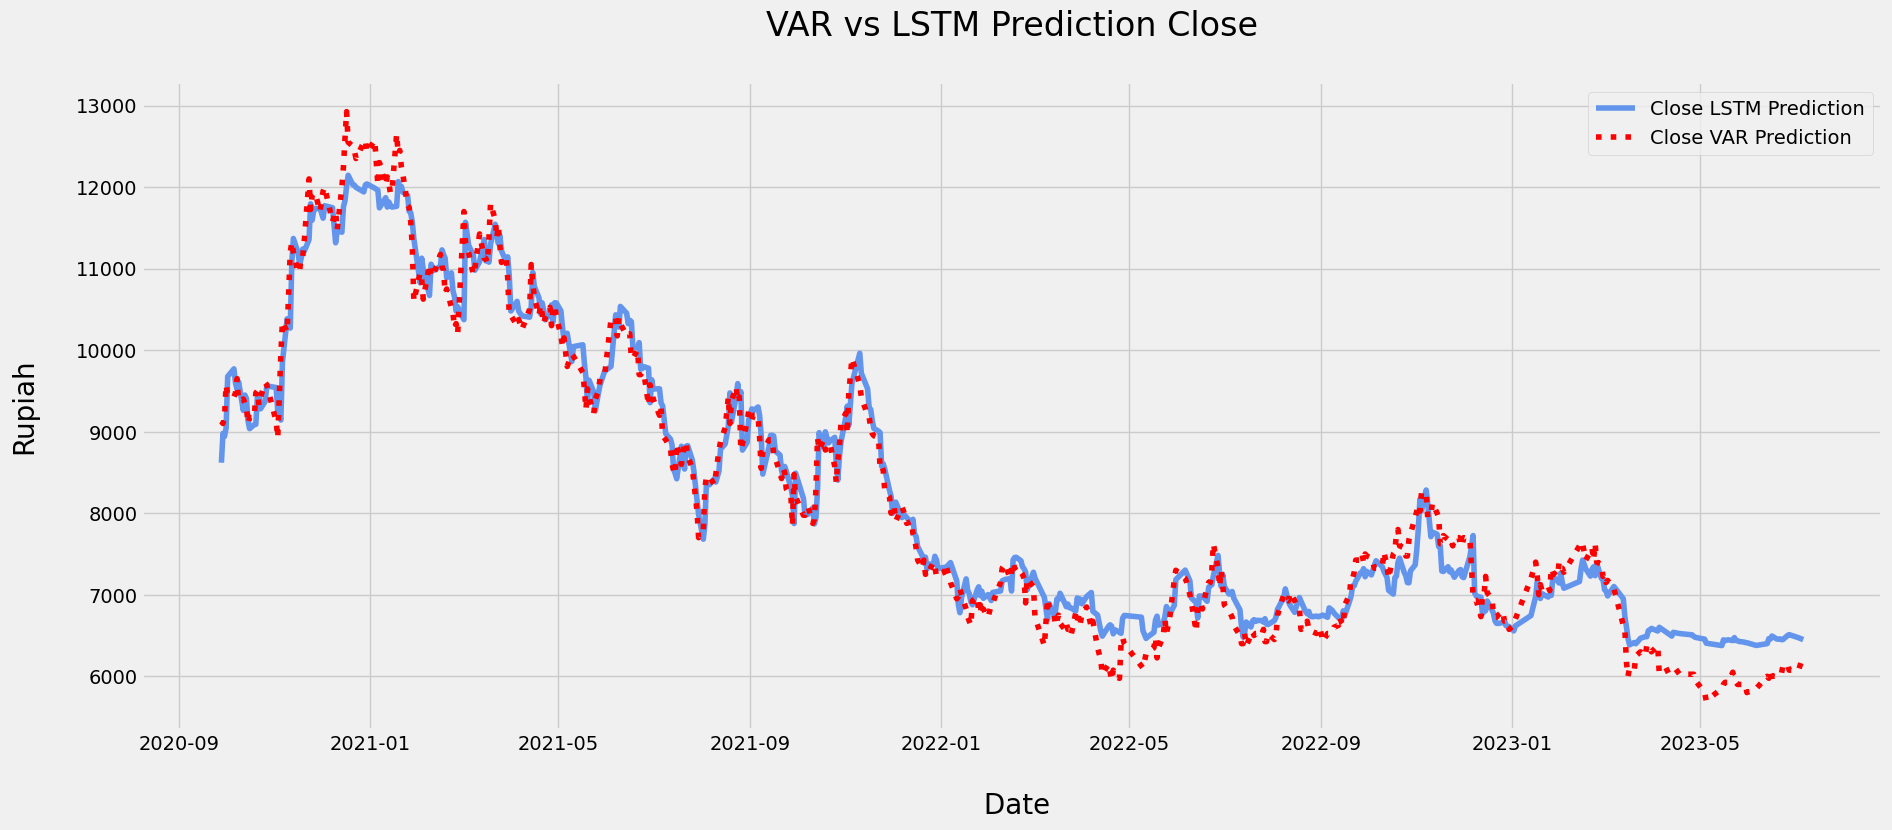

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(test_model_prediction['Prediction Close'], label = ('Close LSTM Prediction'), color='cornflowerblue')
plt.plot(test_data_prediction['Close'], label = ('Close VAR Prediction'), linestyle = 'dotted', color='red')
plt.title('VAR vs LSTM Prediction Close\n', fontsize = 24)
plt.xlabel('\n Date', fontsize = 20)
plt.ylabel('Rupiah\n', fontsize = 20)
plt.legend()
plt.show()

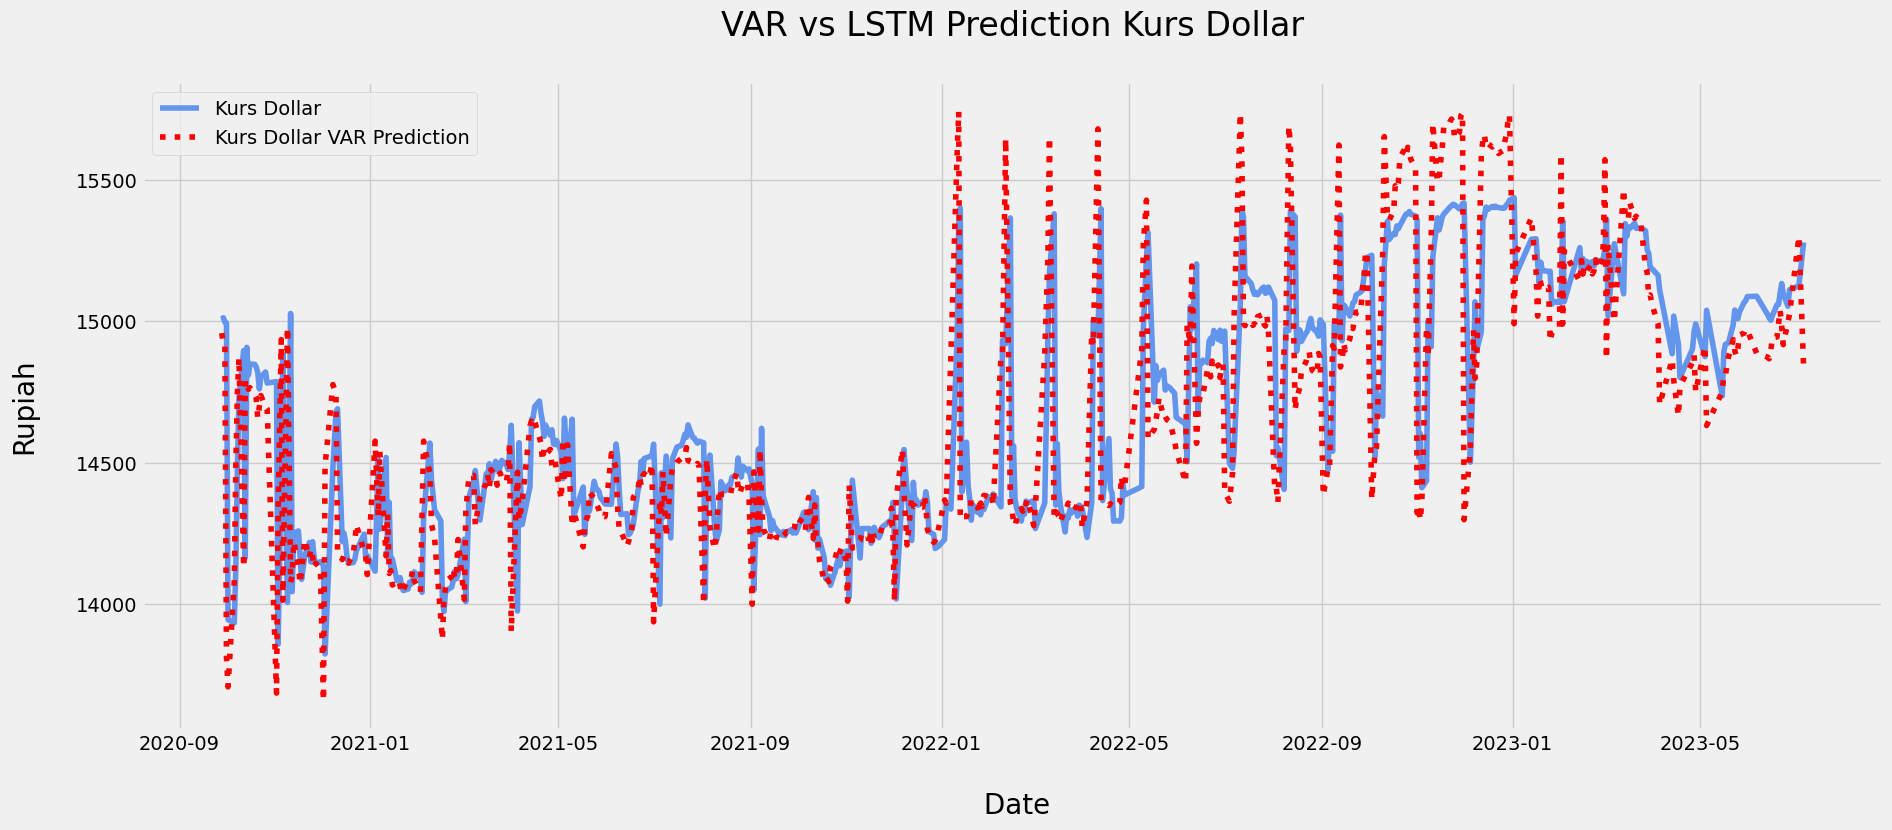

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(test_model_prediction['Prediction Kurs Dollar'], label = ('Kurs Dollar'), color='cornflowerblue')
plt.plot(test_data_prediction['Kurs Dollar'], label = ('Kurs Dollar VAR Prediction'), linestyle = 'dotted', color='red')
plt.title('VAR vs LSTM Prediction Kurs Dollar\n', fontsize = 24)
plt.xlabel('\n Date', fontsize = 20)
plt.ylabel('Rupiah\n', fontsize = 20)
plt.legend()
plt.show()

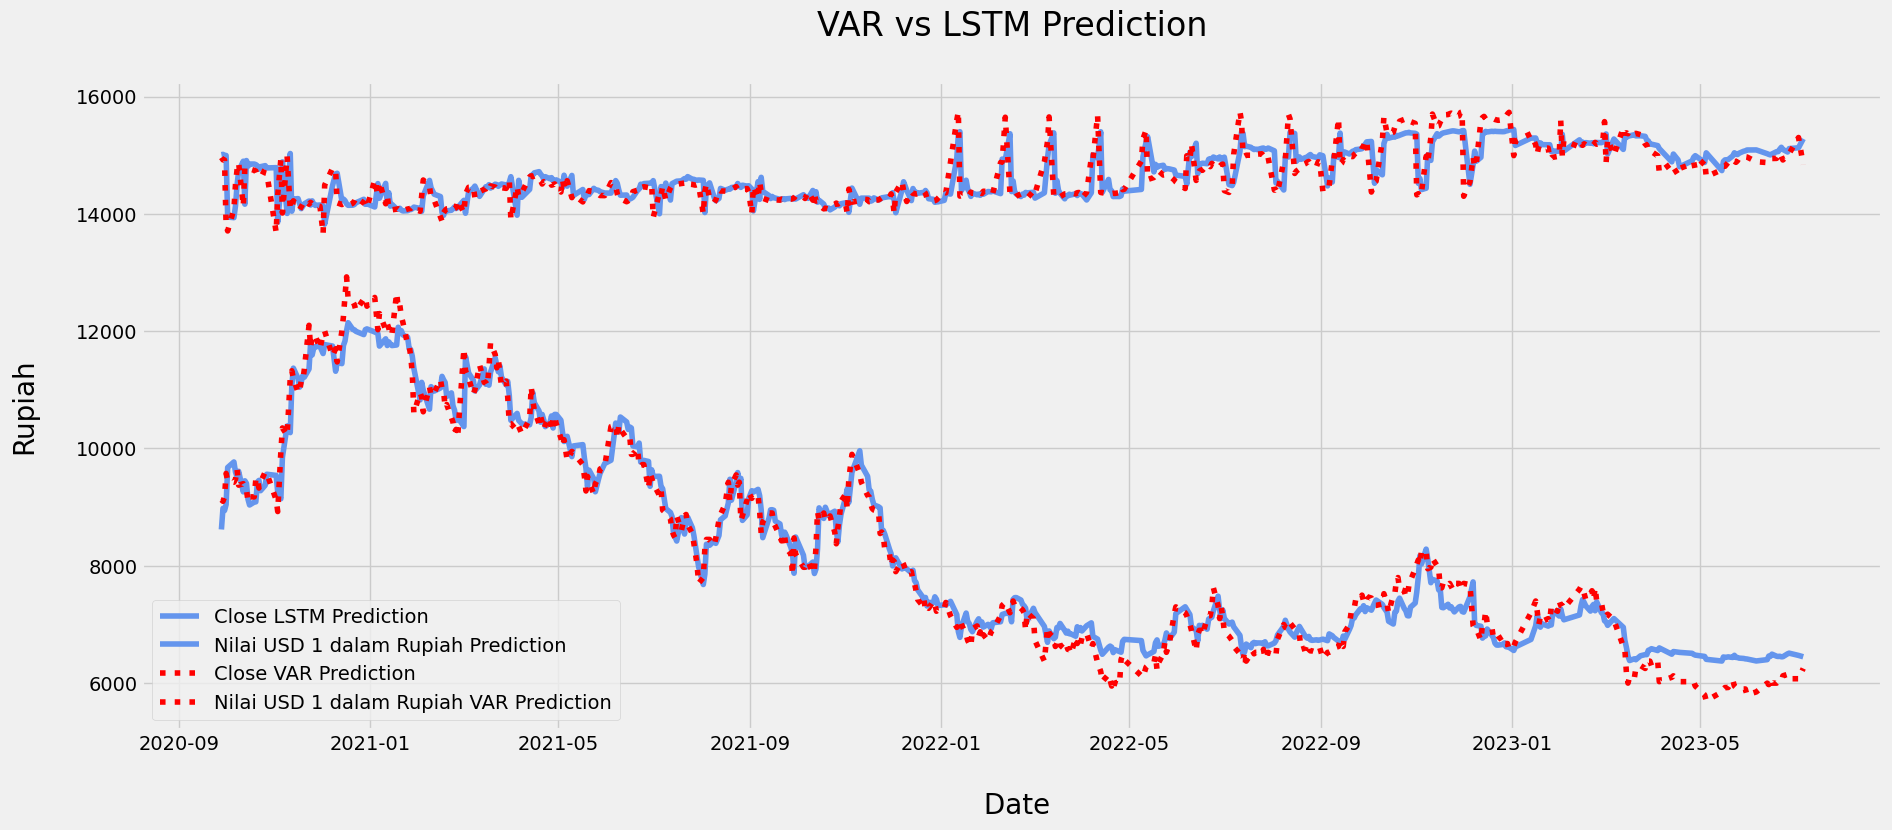

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(test_model_prediction, label=('Close LSTM Prediction', 'Nilai USD 1 dalam Rupiah Prediction'), color= 'cornflowerblue')
plt.plot(test_data_prediction, label=('Close VAR Prediction', 'Nilai USD 1 dalam Rupiah VAR Prediction'), linestyle = 'dotted', color = 'red')
plt.title('VAR vs LSTM Prediction\n', fontsize = 24)
plt.xlabel('\n Date', fontsize = 20)
plt.ylabel('Rupiah\n', fontsize = 20)
plt.legend()
plt.show()

### **Evaluasi Model**

In [ ]:
mse = mean_squared_error(test_data_prediction, test_model_prediction)
rmse = mse**(1/2)
mape = mean_absolute_percentage_error(test_data_prediction, test_model_prediction)
mae = mean_absolute_error(test_data_prediction, test_model_prediction)
akurasi = 100 - mape
print("MSE LSTM model1  is %.2f" % mse)
print("RMSE LSTM model1 is %.2f" % rmse)
print("MAPE LSTM model1 is %.3f" % mape)
print("MAE LSTM model1 is %.2f" % mae)
print("Accuracy LSTM model1 is %.3f" % akurasi)

MSE LSTM model1  is 76288.24
RMSE LSTM model1 is 276.20
MAPE LSTM model1 is 0.021
MAE LSTM model1 is 198.66
Accuracy LSTM model1 is 99.979


### **Peramalan Data Prediksi**

In [ ]:
prediction_scale = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns = ['Close', 'Kurs Dollar'])
prediction_scale.index.names = ['Date']
prediction_scale

Close  Kurs Dollar
Date                             
2010-01-04  0.142857     0.074266
2010-01-06  0.157895     0.090569
2010-01-07  0.150376     0.076561
2010-01-11  0.154135     0.055670
2010-01-12  0.154135     0.069074
...              ...          ...
2023-06-23  0.031955     0.779858
2023-06-26  0.033835     0.789518
2023-06-27  0.028195     0.792899
2023-07-03  0.028195     0.826108
2023-07-06  0.041353     0.770318

[2895 rows x 2 columns]

In [ ]:
time_steps = 30
input_prediction = prediction_scale.tail(time_steps)
input_prediction

Close  Kurs Dollar
Date                             
2023-04-27  0.024436     0.775510
2023-04-28  0.018797     0.759691
2023-05-04  0.007519     0.779254
2023-05-05  0.000000     0.745321
2023-05-15  0.011278     0.759812
2023-05-16  0.015038     0.767057
2023-05-17  0.016917     0.766816
2023-05-19  0.016917     0.774665
2023-05-22  0.026316     0.782031
2023-05-23  0.018797     0.777322
2023-05-24  0.016917     0.775027
2023-05-25  0.015038     0.778288
2023-05-26  0.015038     0.783963
2023-05-29  0.015038     0.784809
2023-05-30  0.015038     0.786499
2023-05-31  0.007519     0.786016
2023-06-06  0.011278     0.776235
2023-06-13  0.022556     0.774544
2023-06-14  0.020677     0.773820
2023-06-15  0.028195     0.777080
2023-06-16  0.022556     0.782876
2023-06-19  0.022556     0.783118
2023-06-20  0.024436     0.789035
2023-06-21  0.024436     0.794590
2023-06-22  0.024436     0.787586
2023-06-23  0.031955     0.779858
2023-06-26  0.033835     0.789518
2023-06-27  0.028195     0.792899
2023-07-03  0.028195     0.826108
2023-07-06  0.041353     0.770318

In [ ]:
x_input = np.array(input_prediction).reshape(1,-1)
x_input = x_input.reshape((time_steps, 1, 2))
x_input

array([[[0.02443609, 0.7755102 ]],

       [[0.01879699, 0.75969086]],

       [[0.0075188 , 0.77925371]],

       [[0.        , 0.74532061]],

       [[0.0112782 , 0.75981162]],

       [[0.01503759, 0.76705712]],

       [[0.01691729, 0.7668156 ]],

       [[0.01691729, 0.7746649 ]],

       [[0.02631579, 0.78203116]],

       [[0.01879699, 0.77732158]],

       [[0.01691729, 0.77502717]],

       [[0.01503759, 0.77828765]],

       [[0.01503759, 0.78396329]],

       [[0.01503759, 0.7848086 ]],

       [[0.01503759, 0.78649922]],

       [[0.0075188 , 0.78601618]],

       [[0.0112782 , 0.77623475]],

       [[0.02255639, 0.77454414]],

       [[0.02067669, 0.77381959]],

       [[0.02819549, 0.77708006]],

       [[0.02255639, 0.78287646]],

       [[0.02255639, 0.78311798]],

       [[0.02443609, 0.78903514]],

       [[0.02443609, 0.79459003]],

       [[0.02443609, 0.78758604]],

       [[0.03195489, 0.77985751]],

       [[0.03383459, 0.78951817]],

       [[0.02819549, 0.79289

In [ ]:
daily_input = list(x_input)
daily_input = daily_input[0].tolist()
daily_input

[[0.024436090225563922, 0.7755102040816326]]

In [ ]:
yhat = model.predict(x_input)
yhat

1/1 [==============================] - 1s 563ms/step


array([[0.05904565, 0.25850976],
       [0.05852847, 0.24911831],
       [0.05727801, 0.259498  ],
       [0.05668982, 0.2399252 ],
       [0.05774909, 0.24869189],
       [0.05810012, 0.25303513],
       [0.05829627, 0.2530241 ],
       [0.05826001, 0.25751102],
       [0.05921744, 0.262419  ],
       [0.05844423, 0.25917062],
       [0.05825843, 0.25771937],
       [0.05804991, 0.25946835],
       [0.0580272 , 0.26275826],
       [0.05802398, 0.26325056],
       [0.05801763, 0.2642366 ],
       [0.0572524 , 0.26341575],
       [0.05767234, 0.2580238 ],
       [0.05885107, 0.2578256 ],
       [0.05865639, 0.25728142],
       [0.05943968, 0.25967076],
       [0.05881552, 0.26265213],
       [0.05881454, 0.2627929 ],
       [0.05899025, 0.26638737],
       [0.05897048, 0.26966435],
       [0.05899569, 0.26553637],
       [0.05983267, 0.2615364 ],
       [0.05999693, 0.26732576],
       [0.0593762 , 0.2689304 ],
       [0.05928791, 0.2889795 ],
       [0.06091104, 0.2566289 ]], dtype=flo

In [ ]:
# Peramalan
from numpy import array

output_forecast= []
time_steps = 30
i = 0

#print(daily_input)
print("{} daily input {}".format(i, daily_input))

#print(x_input)
print("{} daily output {}".format(i, yhat))
daily_input.extend(yhat.tolist())
daily_input = daily_input[1:]

#print(daily_input)
output_forecast.extend(yhat.tolist())
i = i+1

print(output_forecast)

0 daily input [[0.024436090225563922, 0.7755102040816326]]
0 daily output [[0.05904565 0.25850976]
 [0.05852847 0.24911831]
 [0.05727801 0.259498  ]
 [0.05668982 0.2399252 ]
 [0.05774909 0.24869189]
 [0.05810012 0.25303513]
 [0.05829627 0.2530241 ]
 [0.05826001 0.25751102]
 [0.05921744 0.262419  ]
 [0.05844423 0.25917062]
 [0.05825843 0.25771937]
 [0.05804991 0.25946835]
 [0.0580272  0.26275826]
 [0.05802398 0.26325056]
 [0.05801763 0.2642366 ]
 [0.0572524  0.26341575]
 [0.05767234 0.2580238 ]
 [0.05885107 0.2578256 ]
 [0.05865639 0.25728142]
 [0.05943968 0.25967076]
 [0.05881552 0.26265213]
 [0.05881454 0.2627929 ]
 [0.05899025 0.26638737]
 [0.05897048 0.26966435]
 [0.05899569 0.26553637]
 [0.05983267 0.2615364 ]
 [0.05999693 0.26732576]
 [0.0593762  0.2689304 ]
 [0.05928791 0.2889795 ]
 [0.06091104 0.2566289 ]]
[[0.05904564633965492, 0.2585097551345825], [0.05852847173810005, 0.24911831319332123], [0.05727800726890564, 0.2594980001449585], [0.05668981745839119, 0.23992520570755005], 

In [ ]:
len(data)

2895

In [ ]:
len(data)

2895

In [ ]:
data_forecast = scaler.inverse_transform(output_forecast)
data_forecast = np.array(data_forecast)
data_forecast = pd.DataFrame(data_forecast, index=data_update.index, columns = ['Forecast Close', 'Forecast Kurs Dollar'])
data_forecast

Forecast Close  Forecast Kurs Dollar
Date                                            
2023-07-07     6485.307096          10600.719282
2023-07-10     6478.428674          10522.948752
2023-07-11     6461.797497          10608.902939
2023-07-12     6453.974572          10446.820628
2023-07-13     6468.062832          10519.417513
2023-07-14     6472.731536          10555.383896
2023-07-17     6475.340350          10555.292583
2023-07-18     6474.858116          10592.448754
2023-07-20     6487.591927          10633.091618
2023-07-21     6477.308233          10606.191918
2023-07-24     6474.837058          10594.174084
2023-07-25     6472.063750          10608.657380
2023-07-26     6471.761765          10635.901110
2023-07-27     6471.718957          10639.977884
2023-07-28     6471.634530          10648.143278
2023-07-31     6461.456865          10641.345858
2023-08-01     6467.042177          10596.695075
2023-08-02     6482.719191          10595.053901
2023-08-03     6480.129997          10590.547461
2023-08-04     6490.547714          10610.333598
2023-08-07     6482.246370          10635.022280
2023-08-08     6482.233389          10636.187883
2023-08-09     6484.570342          10665.953838
2023-08-10     6484.307449          10693.090459
2023-08-11     6484.642630          10658.906663
2023-08-14     6495.774459          10625.782842
2023-08-15     6497.959206          10673.724610
2023-08-16     6489.703494          10687.012687
2023-08-18     6488.529245          10853.039244
2023-08-21     6510.116792          10585.143927

In [ ]:
data

Close  Kurs Dollar
Date                           
2010-01-04  7600.0         9075
2010-01-06  7800.0         9210
2010-01-07  7700.0         9094
2010-01-11  7750.0         8921
2010-01-12  7750.0         9032
...            ...          ...
2023-06-23  6125.0        14918
2023-06-26  6150.0        14998
2023-06-27  6075.0        15026
2023-07-03  6075.0        15301
2023-07-06  6250.0        14839

[2895 rows x 2 columns]

In [ ]:
week_forecast = np.arange(2895 ,2895 +30)
week_predict = np.arange(2321, 2895)

In [ ]:
week_forecast= data_forecast.index
week_predict= test_index

Text(0.5, 1.0, 'Forecasting Model LSTM\n')

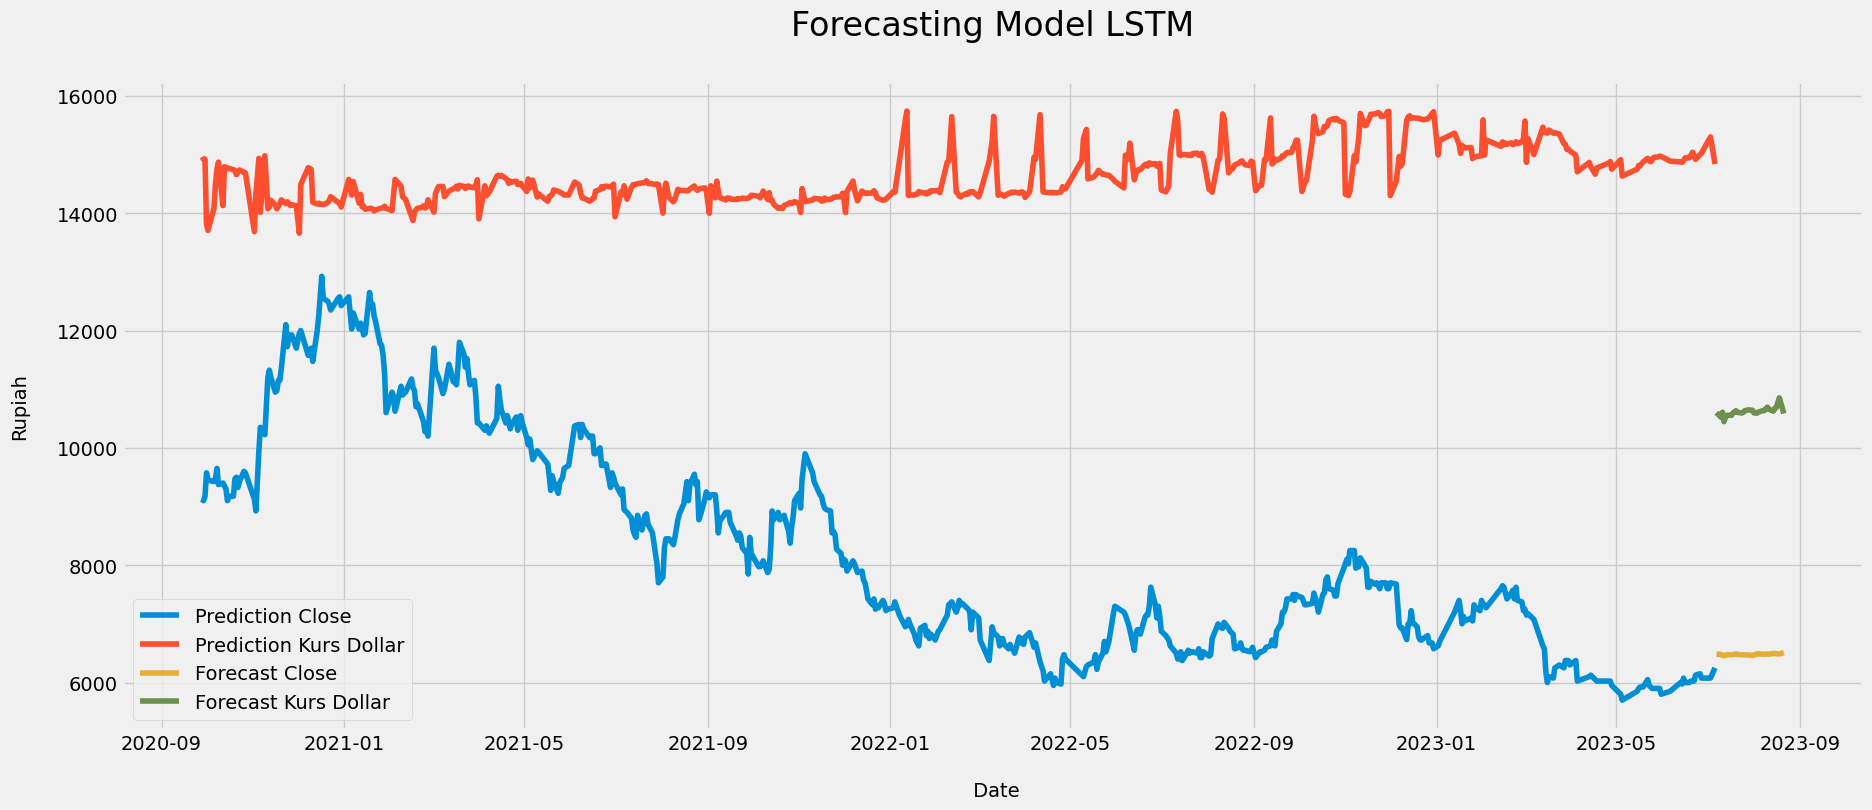

In [ ]:
# Visualization
plt.figure(figsize = (20,8))
plt.plot(week_predict, data[2321:], label = ['Prediction Close', 'Prediction Kurs Dollar'])
plt.plot(week_forecast, data_forecast,label = ['Forecast Close', 'Forecast Kurs Dollar'])
plt.xlabel('\n Date', fontsize = 14)
plt.ylabel('Rupiah\n', fontsize = 14)
plt.legend()
plt.title( 'Forecasting Model LSTM\n', fontsize = 24)

###**Checking Data Update**

Text(0.5, 1.0, 'Forecasting Model LSTM\n')

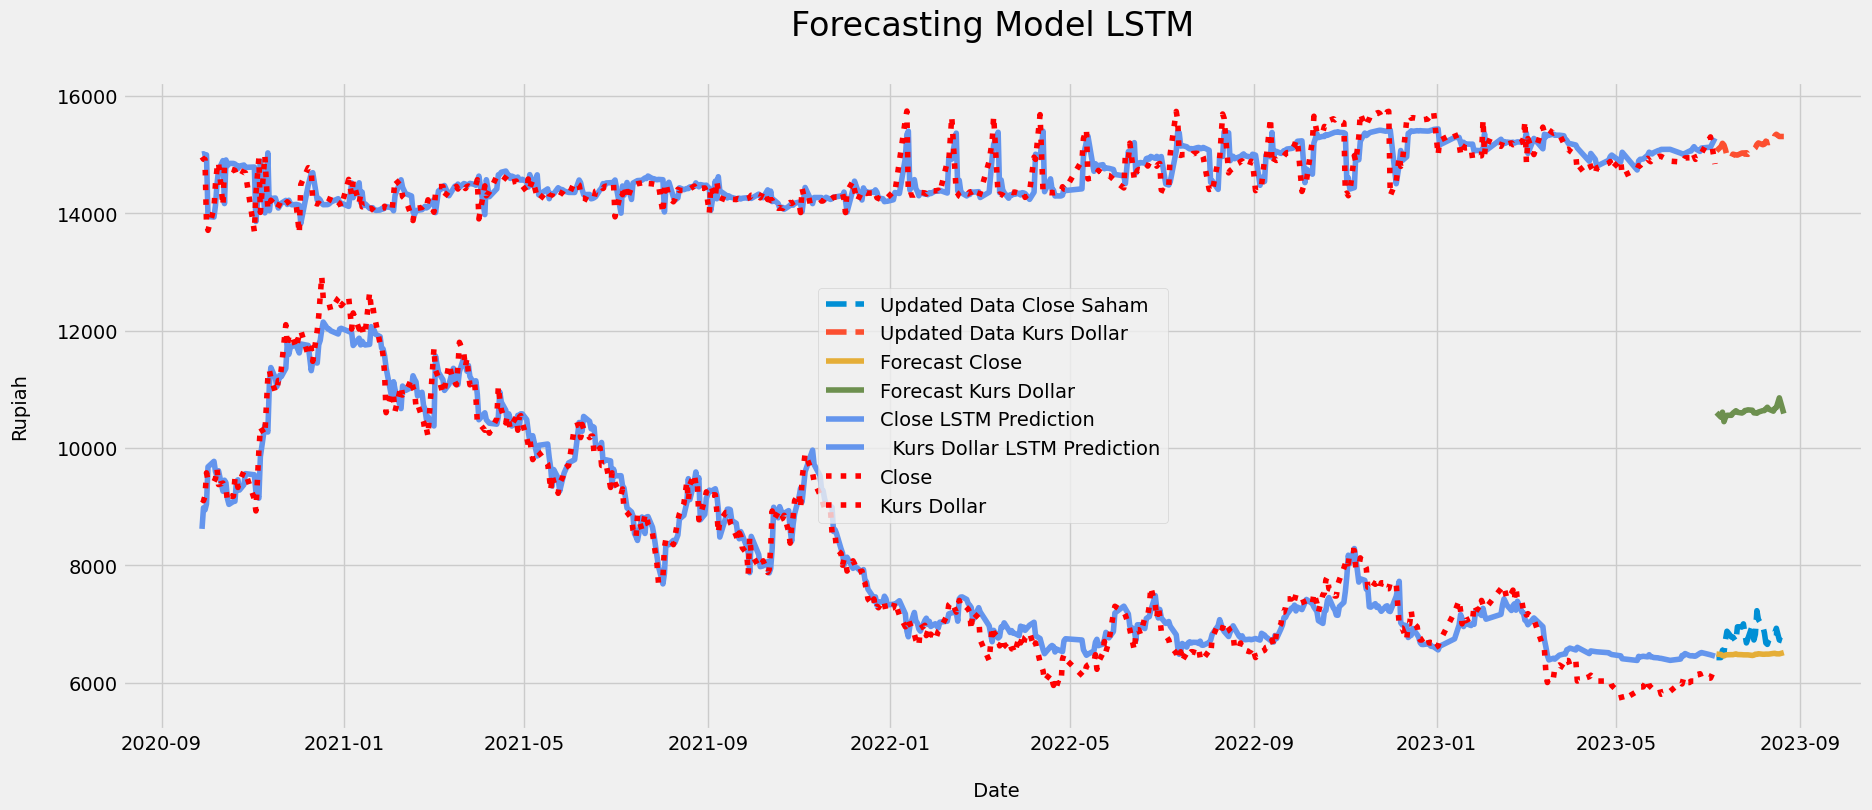

In [ ]:
# Visualization
plt.figure(figsize = (20,8))
plt.plot(data_update.index, data_update, label = ['Updated Data Close Saham', 'Updated Data Kurs Dollar'], linestyle = 'dashed')
plt.plot(week_forecast, data_forecast,label = ['Forecast Close', 'Forecast Kurs Dollar'])
plt.plot(test_model_prediction, label=('Close LSTM Prediction', '  Kurs Dollar LSTM Prediction'), color= 'cornflowerblue')
plt.plot(test_data_prediction, label=('Close', 'Kurs Dollar'), linestyle = 'dotted', color = 'red')
plt.xlabel('\n Date', fontsize = 14)
plt.ylabel('Rupiah\n', fontsize = 14)
plt.legend()
plt.title( 'Forecasting Model LSTM\n', fontsize = 24)

In [ ]:
# Accuracy Prediction Data Update
mse = mean_squared_error(data_update, data_forecast)
rmse = mse**(1/2)
mape = mean_absolute_percentage_error(data_update,data_forecast)
mae = mean_absolute_error(data_update,data_forecast)
akurasi = 100 - mape
print("MSE Hybrid model 2  is %.2f" % mse)
print("RMSE Hybrid model 2 is %.2f" % rmse)
print("MAPE Hybrid model 2 is %.2f" % mape)
print("MAE Hybrid model 2 is %.2f" % mae)
print("Accuracy Hybrid model 2 is %.2f" % akurasi)

MSE Hybrid model 2  is 10236686.27
RMSE Hybrid model 2 is 3199.48
MAPE Hybrid model 2 is 0.17
MAE Hybrid model 2 is 2412.67
Accuracy Hybrid model 2 is 99.83


## **LSTM**

### **Model 1 LSTM input Prediksi VAR**

In [ ]:
prediction

Prediction Close  Prediction Kurs Dollar
Date                                                
2010-01-15       7714.605227             9197.768564
2010-01-18       7819.850256             9237.191983
2010-01-19       7751.394376             9231.923458
2010-01-20       7853.701679             9272.780258
2010-01-21       7980.864797             9292.796871
...                      ...                     ...
2023-06-23       6024.473496            14984.022723
2023-06-26       6124.473496            14920.022723
2023-06-27       6149.473496            15000.022723
2023-07-03       6074.473496            15028.022723
2023-07-06       6074.473496            15303.022723

[2888 rows x 2 columns]

In [ ]:
prediction.shape

(2888, 2)

### **Splitting Data 80:20**

In [ ]:
training_portion = .8

#train size
train_size = int(len(prediction) * training_portion)

training_data_predict = prediction[0: train_size]
testing_data_predict = prediction[train_size:]

print("train_data: ", training_data_predict.shape)
print("test_data: ", testing_data_predict.shape)

train_data:  (2310, 2)
test_data:  (578, 2)


### **Scaling Data Prediksi**

In [ ]:
# MinMax Scaler
scaler = MinMaxScaler()

# Data Train
train_predict_scale = pd.DataFrame(scaler.fit_transform(training_data_predict), columns = ['Close', 'Kurs Dollar'])
test_predict_scale = pd.DataFrame(scaler.fit_transform(testing_data_predict), columns = ['Close', 'Kurs Dollar'])

In [ ]:
train_data_prediction = np.array(train_predict_scale)
test_data_prediction = np.array(test_predict_scale)

In [ ]:
def create_dataset(dataset,time_steps):
    dataX = []
    dataY = []
    for i in range(time_steps, len(dataset)):
            dataX.append(dataset[i - time_steps:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0:dataset.shape[1]])
    return np.array(dataX),np.array(dataY)

In [ ]:
time_steps = 5
X_train_prediction, y_train_prediction = create_dataset(train_data_prediction, time_steps)
X_test_prediction, y_test_prediction = create_dataset(test_data_prediction, time_steps)

### **Hypertuning menggunakan Grid Search**

In [ ]:
def create_model(LSTM_unit, dropout):
  # create model
  model = Sequential()
  model.add(LSTM(units = LSTM_unit, input_shape = (time_steps, 2), activation = 'tanh' ))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))
  model.add(Dense(units = LSTM_unit, activation = 'sigmoid'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))
  model.add(Dense(units = LSTM_unit, activation = 'sigmoid'))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))
  model.add(Dense(2, activation = 'sigmoid'))

  # compile model
  model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

  return model

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0)

#create model
model = KerasRegressor(build_fn = create_model, validation_split = 0.25, callbacks = [es], epochs = 100, verbose = 1)
LSTM_unit = [16, 32, 64]
batch_size = [16, 32, 64]
dropout = [0.1]
param_grid = dict(batch_size = batch_size, LSTM_unit = LSTM_unit, dropout = dropout)

In [ ]:
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = 3, cv = 5, verbose = 1)

In [ ]:
%%time
grid_result_prediction = grid.fit(X_train_prediction, y_train_prediction, validation_split = 0.25, verbose = 1, callbacks = [es])

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Epoch 1/100
108/108 [==============================] - 5s 17ms/step - loss: 0.0274 - val_loss: 0.1248
Epoch 2/100
108/108 [==============================] - 1s 8ms/step - loss: 0.0121 - val_loss: 0.1019
Epoch 3/100
108/108 [==============================] - 1s 7ms/step - loss: 0.0100 - val_loss: 0.0747
Epoch 4/100
108/108 [==============================] - 1s 7ms/step - loss: 0.0087 - val_loss: 0.0436
Epoch 5/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0095 - val_loss: 0.0189
Epoch 6/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0084 - val_loss: 0.0145
Epoch 7/100
108/108 [==============================] - 1s 6ms/step - loss: 0.0080 - val_loss: 0.0040
Epoch 8/100
108/108 [==============================] - 1s 6ms/step - loss: 0.0075 - val_loss: 0.0031
Epoch 9/100
108/108 [==============================] - 1s 5ms/step - loss: 0.0073 - val_loss: 0.0028
Epoch 10/100
108/108 [========

In [ ]:
# melihat hasil parameter terbaik
print("Best: %f using %s" % (grid_result_prediction.best_score_, grid_result_prediction.best_params_))
means = grid_result_prediction.cv_results_['mean_test_score']
stds = grid_result_prediction.cv_results_['std_test_score']
params = grid_result_prediction.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

# mengambil model terbaik
best_model_prediction = grid_result_prediction.best_estimator_.model

Best: -0.002988 using {'LSTM_unit': 64, 'batch_size': 16, 'dropout': 0.1}
-0.004427 (0.002886) with: {'LSTM_unit': 16, 'batch_size': 16, 'dropout': 0.1}
-0.011431 (0.008199) with: {'LSTM_unit': 16, 'batch_size': 32, 'dropout': 0.1}
-0.078330 (0.017420) with: {'LSTM_unit': 16, 'batch_size': 64, 'dropout': 0.1}
-0.003388 (0.001370) with: {'LSTM_unit': 32, 'batch_size': 16, 'dropout': 0.1}
-0.003083 (0.001337) with: {'LSTM_unit': 32, 'batch_size': 32, 'dropout': 0.1}
-0.042770 (0.031132) with: {'LSTM_unit': 32, 'batch_size': 64, 'dropout': 0.1}
-0.002988 (0.001599) with: {'LSTM_unit': 64, 'batch_size': 16, 'dropout': 0.1}
-0.008707 (0.012538) with: {'LSTM_unit': 64, 'batch_size': 32, 'dropout': 0.1}
-0.052595 (0.041521) with: {'LSTM_unit': 64, 'batch_size': 64, 'dropout': 0.1}


### **Membangun Model LSTM untuk Data Prediksi**

In [ ]:
seed = 123
np.random.seed(seed)

In [ ]:
# Build model
model_prediction = Sequential()
model_prediction.add(LSTM(units = 64, input_shape = (time_steps, 2), activation = 'tanh', recurrent_activation = 'sigmoid', return_sequences = False))
model_prediction.add(Dense(units = 32, activation = 'tanh'))
model_prediction.add(Dense(units = 16, activation = 'tanh'))
model_prediction.add(Dense(units = 8, activation = 'tanh'))
model_prediction.add(Dense(2, activation = 'sigmoid'))

# Compile model
model_prediction.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

In [ ]:
%%time
#Early Stopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0)

#Fit Model
history_prediction = model_prediction.fit(X_train_prediction, y_train_prediction, epochs = 100, batch_size = 16, verbose = 1, validation_data = (X_test_prediction, y_test_prediction), callbacks = [es])

Epoch 1/100
145/145 [==============================] - 3s 6ms/step - loss: 0.0135 - val_loss: 0.0144
Epoch 2/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0024 - val_loss: 0.0141
Epoch 3/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 0.0131
Epoch 4/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0019 - val_loss: 0.0129
Epoch 5/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0018 - val_loss: 0.0124
Epoch 6/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 0.0120
Epoch 7/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 0.0118
Epoch 8/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 0.0115
Epoch 9/100
145/145 [==============================] - 1s 4ms/step - loss: 0.0015 - val_loss: 0.0109
Epoch 10/100
145/145 [==============================] - 1s 5ms/step - loss: 0.0015 - val_lo

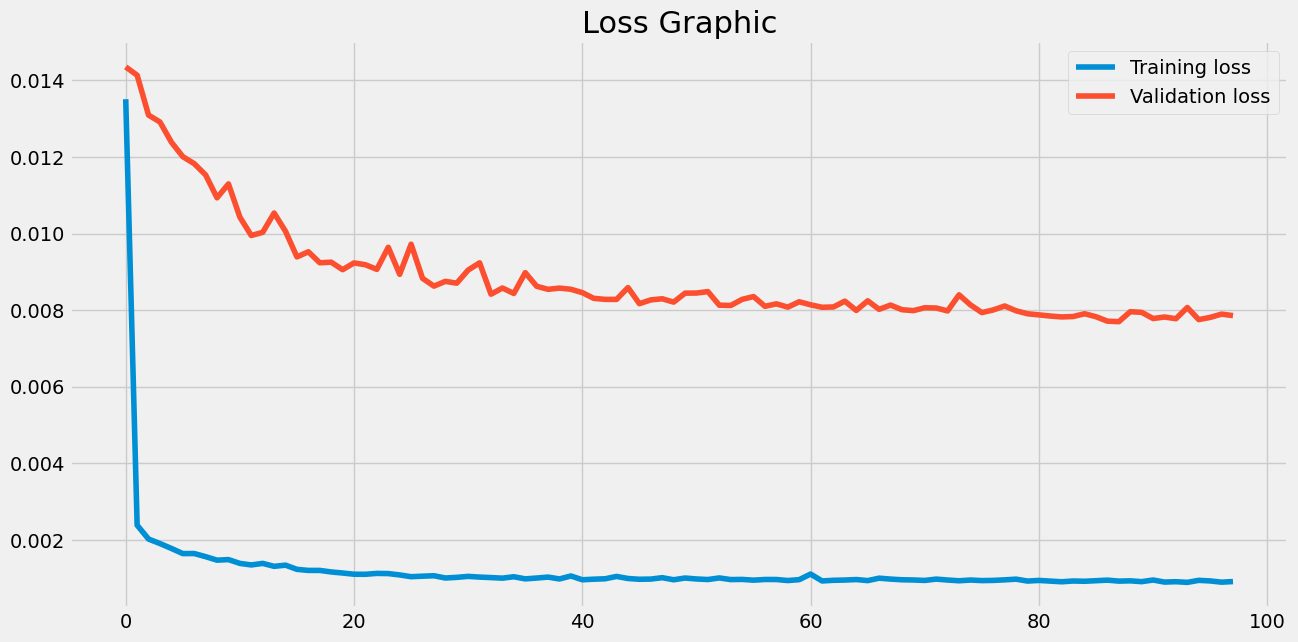

In [ ]:
plt.figure(figsize = (14, 7))
plt.plot(history_prediction.history['loss'], label = 'Training loss')
plt.plot(history_prediction.history['val_loss'], label = 'Validation loss')
plt.title('Loss Graphic', fontsize = 22)
plt.legend()

In [ ]:
test_predict1 = model_prediction.predict(X_test_prediction)
test_predict1

18/18 [==============================] - 0s 2ms/step


array([[0.4260127 , 0.60107684],
       [0.47475076, 0.60801107],
       [0.46696737, 0.6008579 ],
       ...,
       [0.08451214, 0.6314789 ],
       [0.08725604, 0.6659953 ],
       [0.08147693, 0.6833303 ]], dtype=float32)

In [ ]:
test_index = prediction.index[2315:]
test_data_prediction = np.array(testing_data_predict.iloc[5:])
test_data_prediction = pd.DataFrame(test_data_prediction,index=test_index, columns = ['Close', 'Kurs Dollar'])
test_data_prediction.index.names = ['Date']
test_data_prediction

Close   Kurs Dollar
Date                                 
2020-09-29  9124.473496  14961.022723
2020-09-30  9099.473496  14922.022723
2020-10-01  9174.473496  14920.022723
2020-10-02  9574.473496  13814.022723
2020-10-06  9449.473496  13710.022723
...                 ...           ...
2023-06-23  6024.473496  14984.022723
2023-06-26  6124.473496  14920.022723
2023-06-27  6149.473496  15000.022723
2023-07-03  6074.473496  15028.022723
2023-07-06  6074.473496  15303.022723

[573 rows x 2 columns]

In [ ]:
test_model_prediction = scaler.inverse_transform(test_predict1)
test_model_prediction

array([[ 8777.415 , 14913.066 ],
       [ 9129.548 , 14927.51  ],
       [ 9073.3125, 14912.61  ],
       ...,
       [ 6310.0737, 14976.394 ],
       [ 6329.8984, 15048.291 ],
       [ 6288.1445, 15084.399 ]], dtype=float32)

In [ ]:
test_model_prediction = pd.DataFrame(test_model_prediction,index=test_index, columns = ['Prediction Close', 'Prediction Kurs Dollar'])
test_model_prediction.index.names = ['Date']
test_model_prediction

Prediction Close  Prediction Kurs Dollar
Date                                                
2020-09-29       8777.415039            14913.066406
2020-09-30       9129.547852            14927.509766
2020-10-01       9073.312500            14912.610352
2020-10-02       9170.464844            14916.163086
2020-10-06       9572.562500            13955.560547
...                      ...                     ...
2023-06-23       6242.612793            15103.488281
2023-06-26       6250.417480            15054.325195
2023-06-27       6310.073730            14976.393555
2023-07-03       6329.898438            15048.291016
2023-07-06       6288.144531            15084.399414

[573 rows x 2 columns]

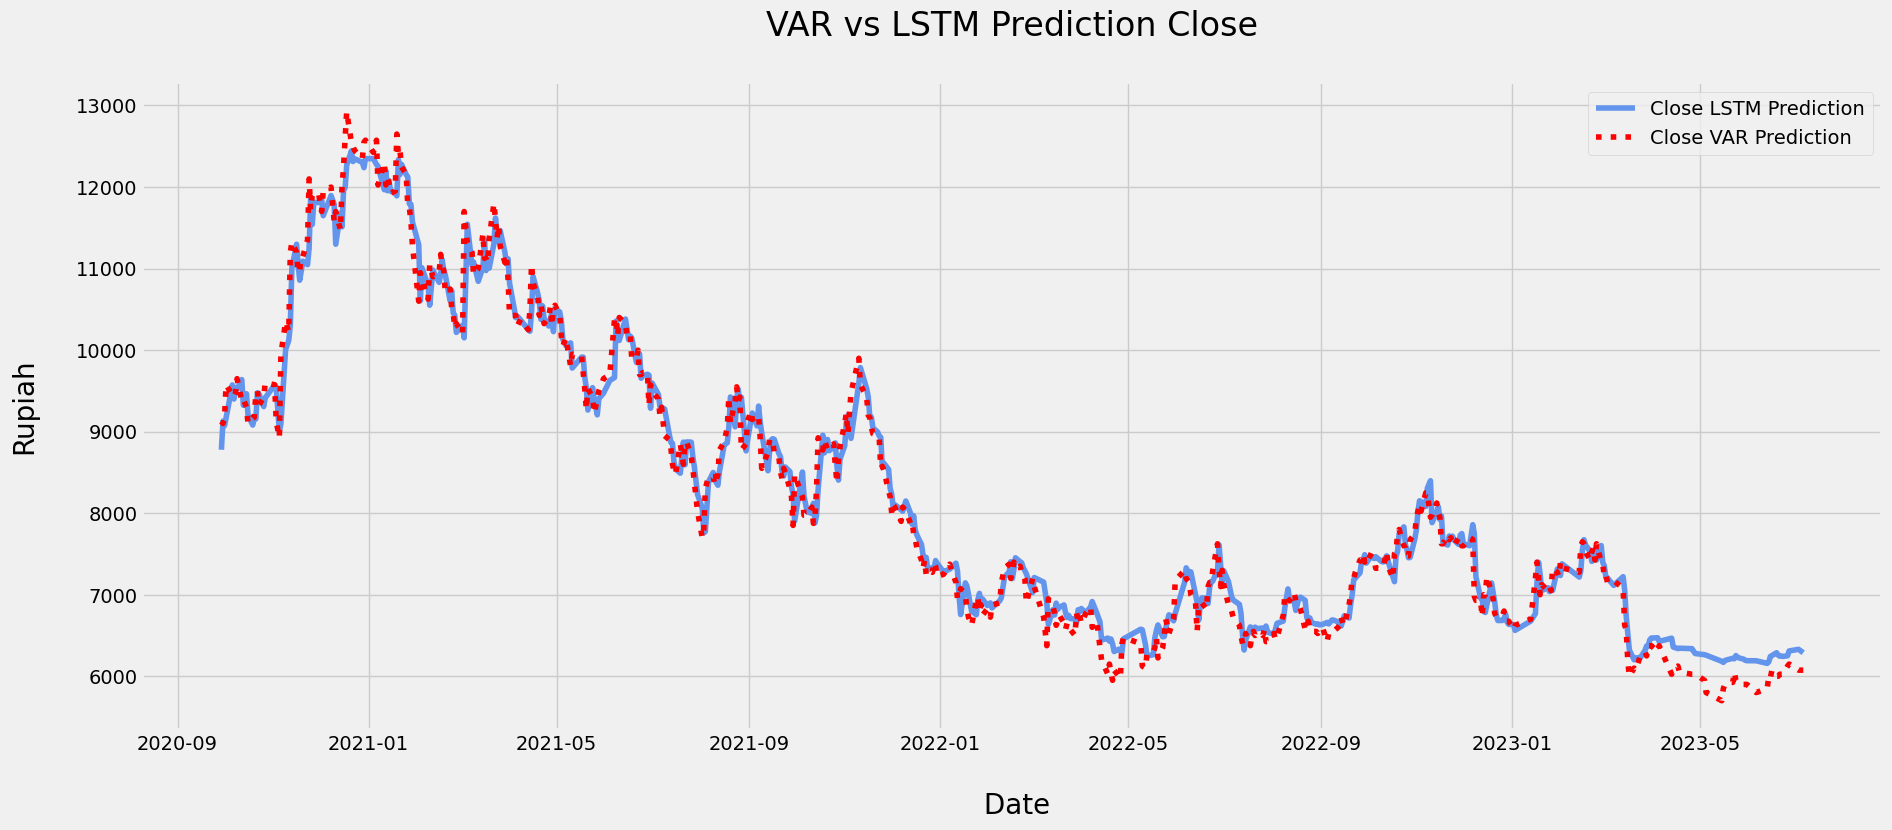

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(test_model_prediction['Prediction Close'], label = ('Close LSTM Prediction'), color='cornflowerblue')
plt.plot(test_data_prediction['Close'], label = ('Close VAR Prediction'), linestyle = 'dotted', color='red')
plt.title('VAR vs LSTM Prediction Close\n', fontsize = 24)
plt.xlabel('\n Date', fontsize = 20)
plt.ylabel('Rupiah\n', fontsize = 20)
plt.legend()
plt.show()

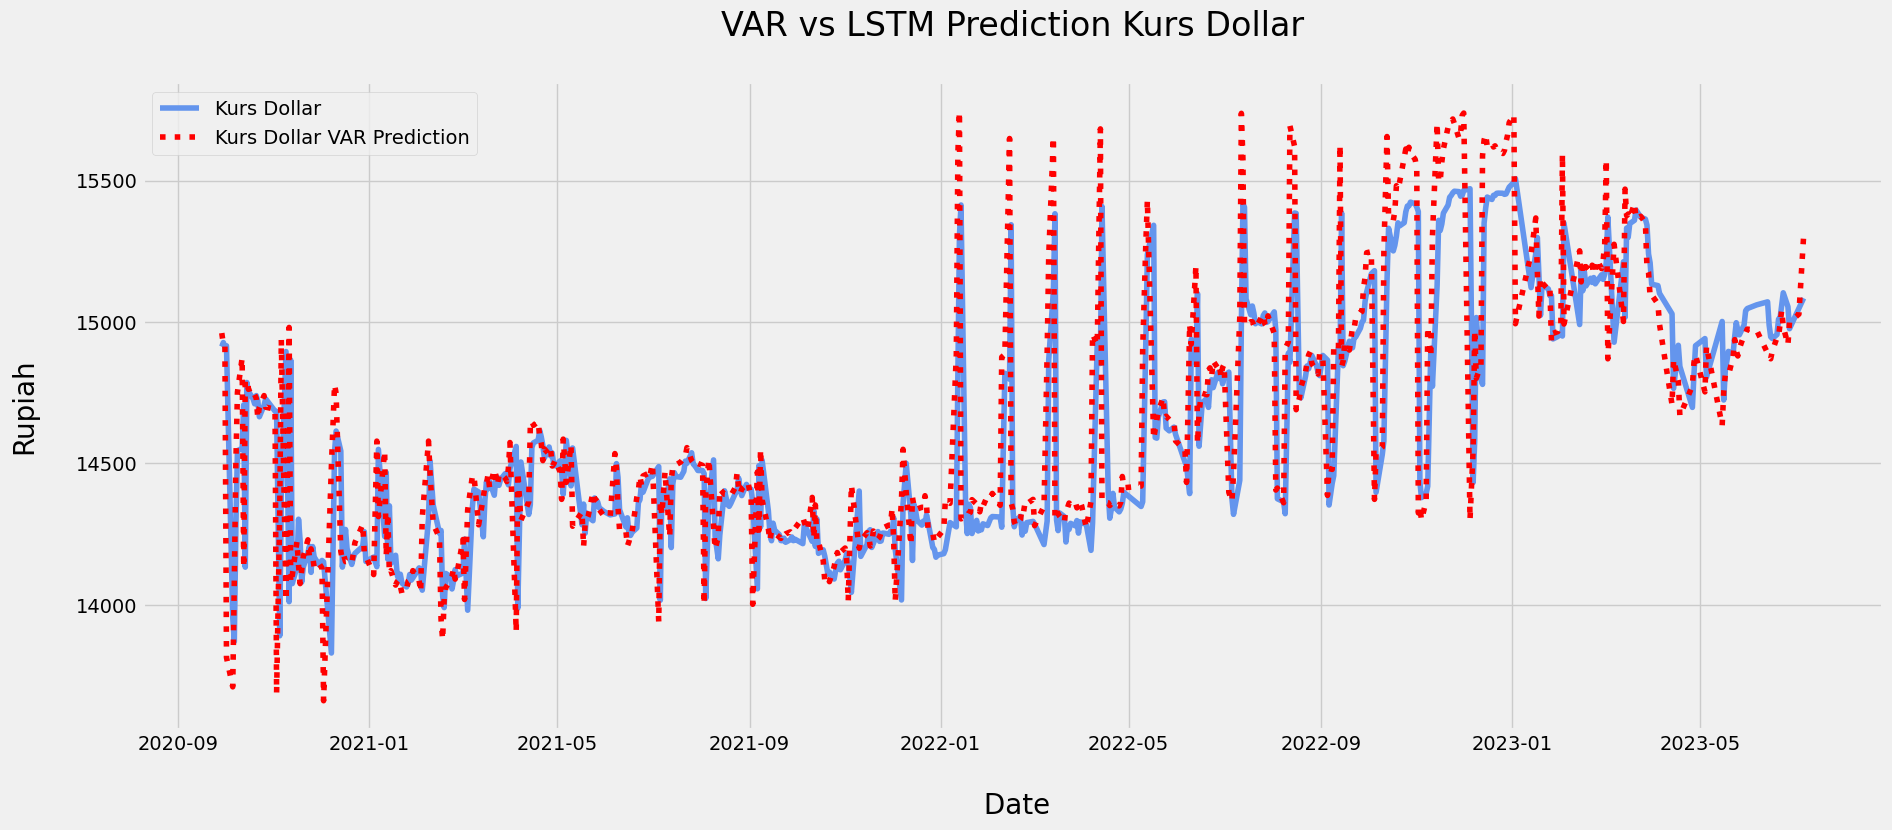

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(test_model_prediction['Prediction Kurs Dollar'], label = ('Kurs Dollar'), color='cornflowerblue')
plt.plot(test_data_prediction['Kurs Dollar'], label = ('Kurs Dollar VAR Prediction'), linestyle = 'dotted', color='red')
plt.title('VAR vs LSTM Prediction Kurs Dollar\n', fontsize = 24)
plt.xlabel('\n Date', fontsize = 20)
plt.ylabel('Rupiah\n', fontsize = 20)
plt.legend()
plt.show()

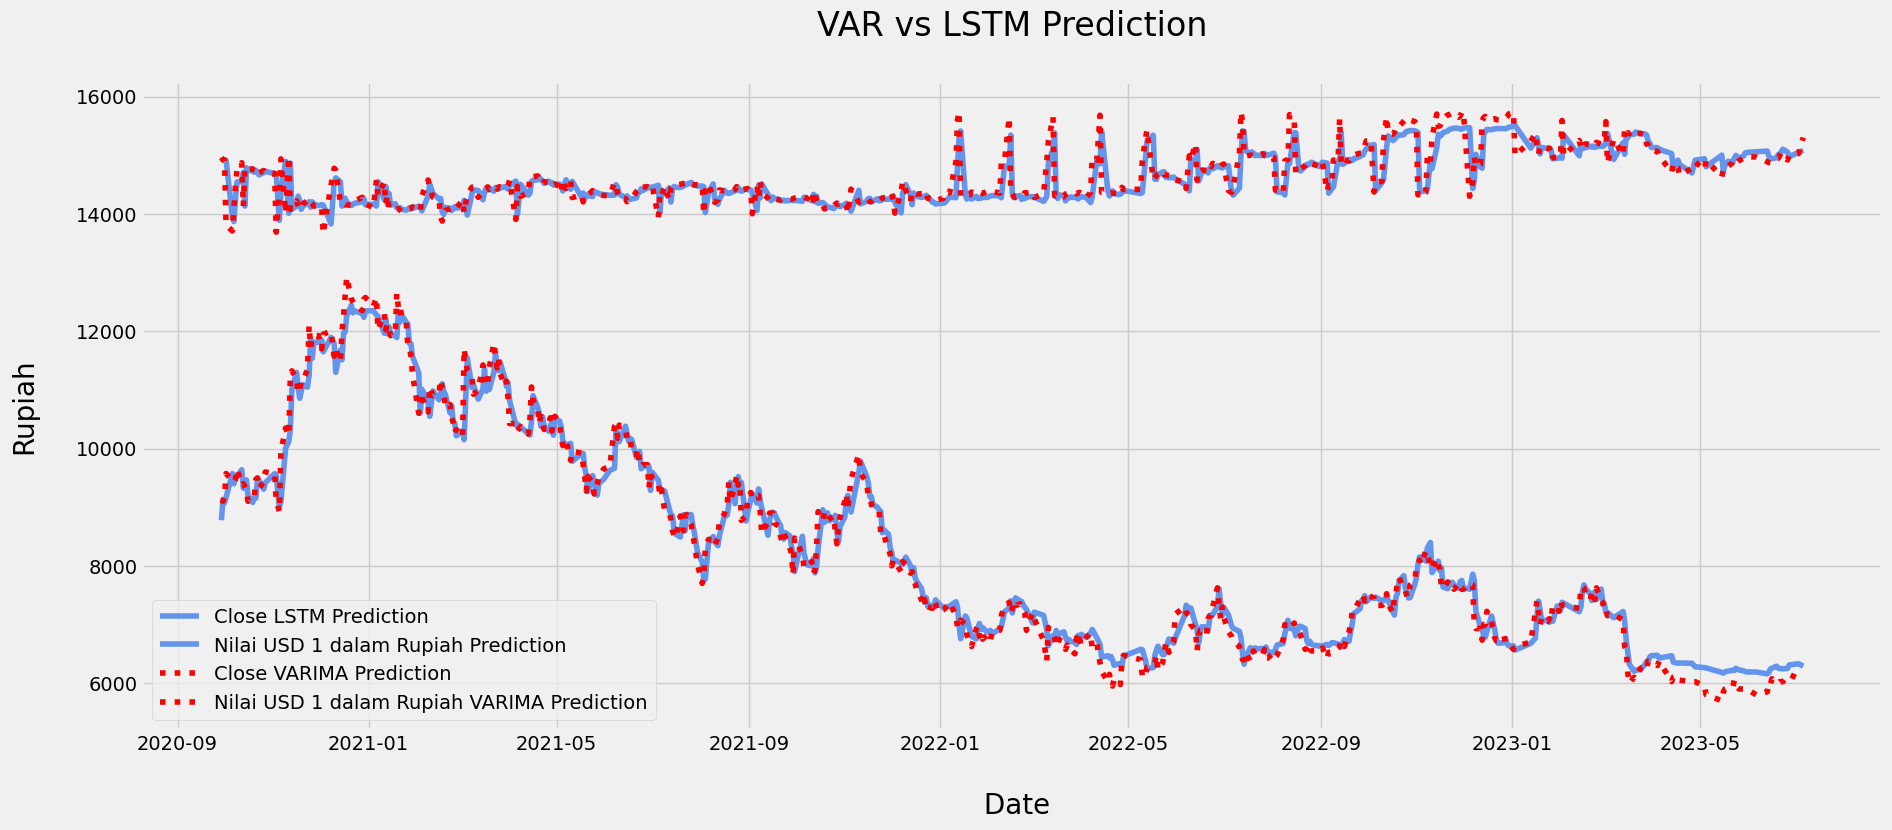

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(test_model_prediction, label=('Close LSTM Prediction', 'Nilai USD 1 dalam Rupiah Prediction'), color= 'cornflowerblue')
plt.plot(test_data_prediction, label=('Close VARIMA Prediction', 'Nilai USD 1 dalam Rupiah VARIMA Prediction'), linestyle = 'dotted', color = 'red')
plt.title('VAR vs LSTM Prediction\n', fontsize = 24)
plt.xlabel('\n Date', fontsize = 20)
plt.ylabel('Rupiah\n', fontsize = 20)
plt.legend()
plt.show()

### **Evaluasi Model**

In [ ]:
mse = mean_squared_error(test_data_prediction, test_model_prediction)
rmse = mse**(1/2)
mape = mean_absolute_percentage_error(test_data_prediction, test_model_prediction)
mae = mean_absolute_error(test_data_prediction, test_model_prediction)
akurasi = 100 - mape
print("MSE LSTM model1  is %.2f" % mse)
print("RMSE LSTM model1 is %.2f" % rmse)
print("MAPE LSTM model1 is %.3f" % mape)
print("MAE LSTM model1 is %.2f" % mae)
print("Accuracy LSTM model1 is %.3f" % akurasi)

MSE LSTM model1  is 58352.00
RMSE LSTM model1 is 241.56
MAPE LSTM model1 is 0.016
MAE LSTM model1 is 158.39
Accuracy LSTM model1 is 99.984


### **Peramalan Data Prediksi**

In [ ]:
prediction_scale = pd.DataFrame(scaler.fit_transform(prediction), index=prediction.index, columns = ['Close', 'Kurs Dollar'])
prediction_scale.index.names = ['Date']
prediction_scale

Close  Kurs Dollar
Date                             
2010-01-15  0.151514     0.088847
2010-01-18  0.159427     0.093608
2010-01-19  0.154280     0.092972
2010-01-20  0.161972     0.097906
2010-01-21  0.171533     0.100323
...              ...          ...
2023-06-23  0.024436     0.787586
2023-06-26  0.031955     0.779858
2023-06-27  0.033835     0.789518
2023-07-03  0.028195     0.792899
2023-07-06  0.028195     0.826108

[2888 rows x 2 columns]

In [ ]:
time_steps = 30
input_prediction = prediction_scale.tail(time_steps)
input_prediction

Close  Kurs Dollar
Date                             
2023-04-27  0.024436     0.772250
2023-04-28  0.024436     0.775510
2023-05-04  0.018797     0.759691
2023-05-05  0.007519     0.779254
2023-05-15  0.000000     0.745321
2023-05-16  0.011278     0.759812
2023-05-17  0.015038     0.767057
2023-05-19  0.016917     0.766816
2023-05-22  0.016917     0.774665
2023-05-23  0.026316     0.782031
2023-05-24  0.018797     0.777322
2023-05-25  0.016917     0.775027
2023-05-26  0.015038     0.778288
2023-05-29  0.015038     0.783963
2023-05-30  0.015038     0.784809
2023-05-31  0.015038     0.786499
2023-06-06  0.007519     0.786016
2023-06-13  0.011278     0.776235
2023-06-14  0.022556     0.774544
2023-06-15  0.020677     0.773820
2023-06-16  0.028195     0.777080
2023-06-19  0.022556     0.782876
2023-06-20  0.022556     0.783118
2023-06-21  0.024436     0.789035
2023-06-22  0.024436     0.794590
2023-06-23  0.024436     0.787586
2023-06-26  0.031955     0.779858
2023-06-27  0.033835     0.789518
2023-07-03  0.028195     0.792899
2023-07-06  0.028195     0.826108

In [ ]:
x_input_prediction = np.array(input_prediction).reshape(1,-1)
x_input_prediction = x_input_prediction.reshape((time_steps, 1, 2))
x_input_prediction

array([[[0.02443609, 0.77224973]],

       [[0.02443609, 0.7755102 ]],

       [[0.01879699, 0.75969086]],

       [[0.0075188 , 0.77925371]],

       [[0.        , 0.74532061]],

       [[0.0112782 , 0.75981162]],

       [[0.01503759, 0.76705712]],

       [[0.01691729, 0.7668156 ]],

       [[0.01691729, 0.7746649 ]],

       [[0.02631579, 0.78203116]],

       [[0.01879699, 0.77732158]],

       [[0.01691729, 0.77502717]],

       [[0.01503759, 0.77828765]],

       [[0.01503759, 0.78396329]],

       [[0.01503759, 0.7848086 ]],

       [[0.01503759, 0.78649922]],

       [[0.0075188 , 0.78601618]],

       [[0.0112782 , 0.77623475]],

       [[0.02255639, 0.77454414]],

       [[0.02067669, 0.77381959]],

       [[0.02819549, 0.77708006]],

       [[0.02255639, 0.78287646]],

       [[0.02255639, 0.78311798]],

       [[0.02443609, 0.78903514]],

       [[0.02443609, 0.79459003]],

       [[0.02443609, 0.78758604]],

       [[0.03195489, 0.77985751]],

       [[0.03383459, 0.78951

In [ ]:
daily_input_prediction = list(x_input_prediction)
daily_input_prediction = daily_input_prediction[0].tolist()
daily_input_prediction

[[0.024436090225563922, 0.7722497282936842]]

In [ ]:
yhat_prediction = model_prediction.predict(x_input_prediction)
yhat_prediction

1/1 [==============================] - 0s 300ms/step


array([[0.10570455, 0.75476915],
       [0.1057524 , 0.7566654 ],
       [0.1028194 , 0.74837434],
       [0.09782462, 0.7618261 ],
       [0.09420579, 0.7434285 ],
       [0.09932306, 0.7498736 ],
       [0.10114016, 0.75343555],
       [0.1020188 , 0.7529464 ],
       [0.10211795, 0.7575109 ],
       [0.10678013, 0.76009244],
       [0.10304692, 0.75870246],
       [0.10212263, 0.7577195 ],
       [0.10127881, 0.7599234 ],
       [0.10135255, 0.76313585],
       [0.10136376, 0.7636106 ],
       [0.10138632, 0.76455706],
       [0.0979019 , 0.76560915],
       [0.09950584, 0.75943017],
       [0.1048203 , 0.7564362 ],
       [0.10390076, 0.7563498 ],
       [0.10763872, 0.75692254],
       [0.10494182, 0.761217  ],
       [0.10494544, 0.76135415],
       [0.1059595 , 0.76437384],
       [0.10604867, 0.7674672 ],
       [0.10593665, 0.76355994],
       [0.10958233, 0.75788957],
       [0.1107173 , 0.76309884],
       [0.10789902, 0.7659132 ],
       [0.10850785, 0.7836931 ]], dtype=flo

In [ ]:
# Peramalan
from numpy import array

output_peramalan_prediction = []
time_steps = 30
i = 0

#print(daily_input)
print("{} daily input {}".format(i, daily_input_prediction))

#print(x_input)
print("{} daily output {}".format(i, yhat_prediction))
daily_input_prediction.extend(yhat_prediction.tolist())
daily_input_prediction = daily_input_prediction[1:]

#print(daily_input)
output_peramalan_prediction.extend(yhat_prediction.tolist())
i = i+1

print(output_peramalan_prediction)

0 daily input [[0.024436090225563922, 0.7722497282936842]]
0 daily output [[0.10570455 0.75476915]
 [0.1057524  0.7566654 ]
 [0.1028194  0.74837434]
 [0.09782462 0.7618261 ]
 [0.09420579 0.7434285 ]
 [0.09932306 0.7498736 ]
 [0.10114016 0.75343555]
 [0.1020188  0.7529464 ]
 [0.10211795 0.7575109 ]
 [0.10678013 0.76009244]
 [0.10304692 0.75870246]
 [0.10212263 0.7577195 ]
 [0.10127881 0.7599234 ]
 [0.10135255 0.76313585]
 [0.10136376 0.7636106 ]
 [0.10138632 0.76455706]
 [0.0979019  0.76560915]
 [0.09950584 0.75943017]
 [0.1048203  0.7564362 ]
 [0.10390076 0.7563498 ]
 [0.10763872 0.75692254]
 [0.10494182 0.761217  ]
 [0.10494544 0.76135415]
 [0.1059595  0.76437384]
 [0.10604867 0.7674672 ]
 [0.10593665 0.76355994]
 [0.10958233 0.75788957]
 [0.1107173  0.76309884]
 [0.10789902 0.7659132 ]
 [0.10850785 0.7836931 ]]
[[0.10570454597473145, 0.7547691464424133], [0.10575240105390549, 0.7566654086112976], [0.10281939804553986, 0.748374342918396], [0.09782461822032928, 0.7618260979652405], [0.

In [ ]:
len(prediction)

2888

In [ ]:
len(test_model_prediction)

573

In [ ]:
output_forecast_prediction = scaler.inverse_transform(output_peramalan_prediction)
output_forecast_prediction = np.array(output_forecast_prediction)
output_forecast_prediction = pd.DataFrame(output_forecast_prediction, index=data_update.index, columns = ['Forecast Close', 'Forecast Kurs Dollar'])
output_forecast_prediction

Forecast Close  Forecast Kurs Dollar
Date                                            
2023-07-07     7105.343958          14712.266025
2023-07-10     7105.980430          14727.968972
2023-07-11     7066.971490          14659.310657
2023-07-12     7000.540919          14770.704640
2023-07-13     6952.410494          14618.354366
2023-07-14     7020.470150          14671.725827
2023-07-17     7044.637576          14701.222530
2023-07-18     7056.323482          14697.171669
2023-07-20     7057.642208          14734.970490
2023-07-21     7119.649181          14756.348196
2023-07-24     7069.997485          14744.837769
2023-07-25     7057.704537          14736.698041
2023-07-26     7046.481692          14754.948386
2023-07-27     7047.462413          14781.550700
2023-07-28     7047.611448          14785.482113
2023-07-31     7047.911600          14793.319766
2023-08-01     7001.568808          14802.032054
2023-08-02     7022.901191          14750.863961
2023-08-03     7093.583435          14726.071133
2023-08-04     7081.353610          14725.355433
2023-08-07     7131.068428          14730.098302
2023-08-08     7095.199638          14765.660684
2023-08-09     7095.247896          14766.796426
2023-08-10     7108.734911          14791.802483
2023-08-11     7109.920852          14817.418612
2023-08-14     7108.430894          14785.062565
2023-08-15     7156.918450          14738.106242
2023-08-16     7172.013640          14781.244183
2023-08-18     7134.530431          14804.549837
2023-08-21     7142.627892          14951.785078

In [ ]:
prediction

Prediction Close  Prediction Kurs Dollar
Date                                                
2010-01-15       7714.605227             9197.768564
2010-01-18       7819.850256             9237.191983
2010-01-19       7751.394376             9231.923458
2010-01-20       7853.701679             9272.780258
2010-01-21       7980.864797             9292.796871
...                      ...                     ...
2023-06-23       6024.473496            14984.022723
2023-06-26       6124.473496            14920.022723
2023-06-27       6149.473496            15000.022723
2023-07-03       6074.473496            15028.022723
2023-07-06       6074.473496            15303.022723

[2888 rows x 2 columns]

In [ ]:
week_forecast = np.arange(2888 ,2888 +30)
week_predict = np.arange(2315, 2888)

In [ ]:
week_forecast= output_forecast_prediction.index
week_predict= test_index

Text(0.5, 1.0, 'Forecasting Model LSTM for Prediction\n')

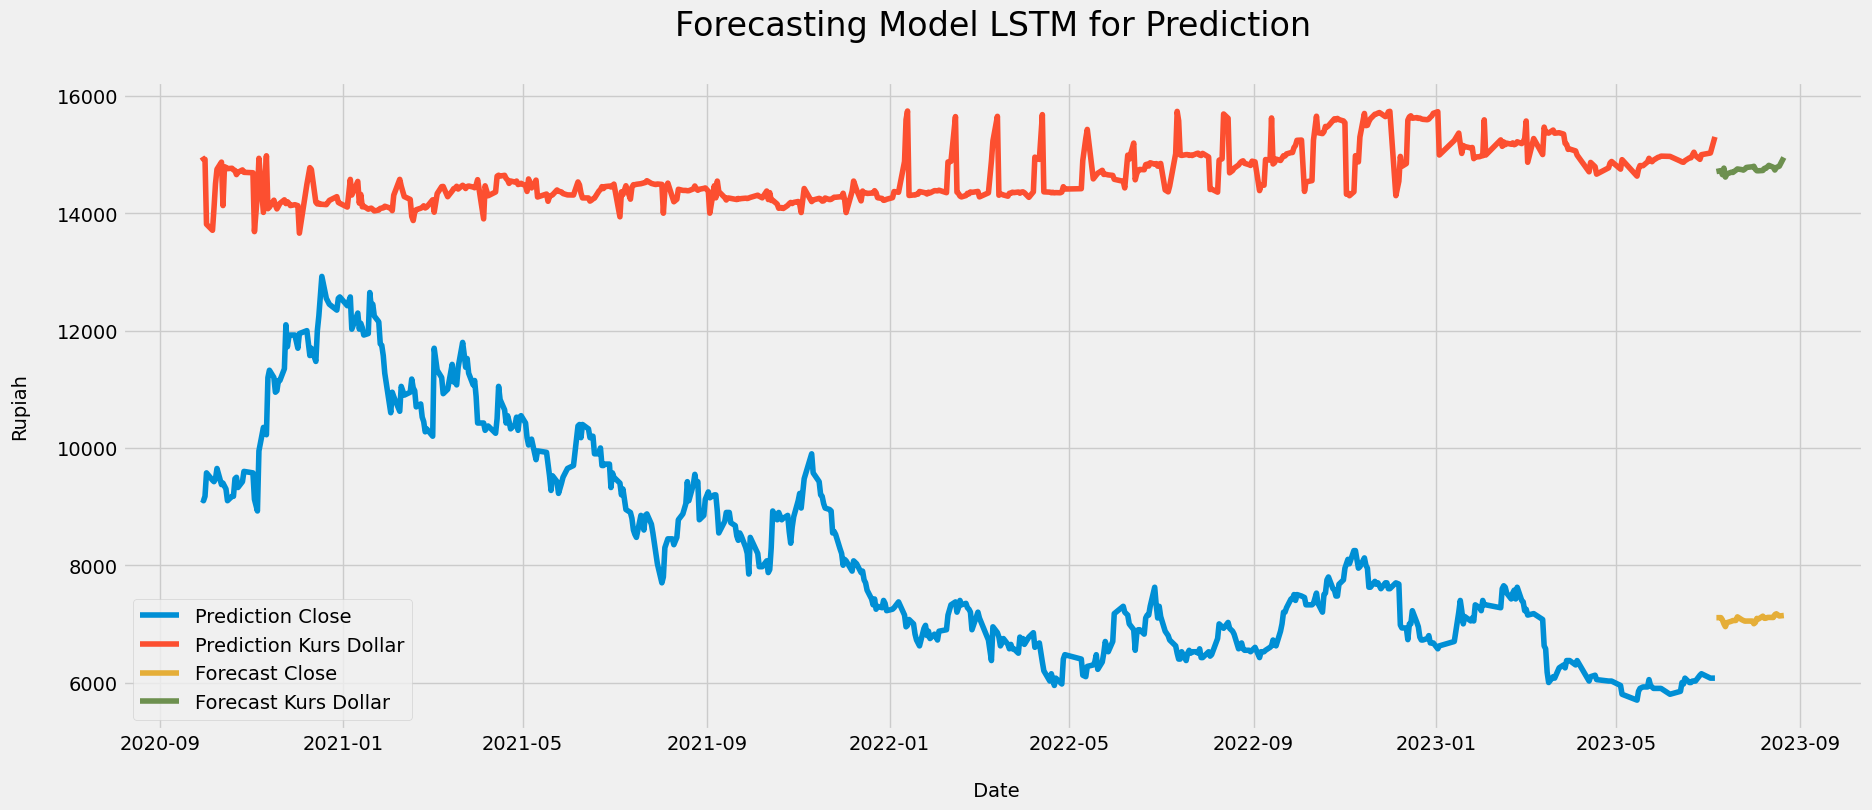

In [ ]:
# Visualization
plt.figure(figsize = (20,8))
plt.plot(week_predict, prediction[2315:], label = ['Prediction Close', 'Prediction Kurs Dollar'])
plt.plot(week_forecast, output_forecast_prediction,label = ['Forecast Close', 'Forecast Kurs Dollar'])
plt.xlabel('\n Date', fontsize = 14)
plt.ylabel('Rupiah\n', fontsize = 14)
plt.legend()
plt.title( 'Forecasting Model LSTM for Prediction\n', fontsize = 24)

### **Model 2 LSTM input Residual VARIMA**

In [ ]:
residual

Close  Kurs Dollar
Date                               
2010-01-15   66.921779    70.390527
2010-01-18  -45.891920    47.730930
2010-01-19  103.969083    40.321869
2010-01-20  142.864737    95.611971
2010-01-21  -93.437225    85.895414
...                ...          ...
2023-06-23  103.293593   -47.199322
2023-06-26   20.225733    72.264123
2023-06-27  -74.519237    37.859885
2023-07-03    4.504500   283.357758
2023-07-06  171.490311  -382.783256

[2888 rows x 2 columns]

In [ ]:
residual.shape

(2888, 2)

### **Splitting Data 80:20**

In [ ]:
training_portion = .8

#train size
training_size = int(len(residual) * training_portion)

training_data_residual = residual[0: train_size]
testing_data_residual = residual[train_size:]

print("train_data: ", training_data_residual.shape)
print("test_data: ", testing_data_residual.shape)

train_data:  (2310, 2)
test_data:  (578, 2)


In [ ]:
# Standard Scaler
scaler = MinMaxScaler()

# Data Train
training_residual_scale = pd.DataFrame(scaler.fit_transform(training_data_residual), columns = ['Residual Close', 'Residual Kurs Dollar'])
testing_residual_scale = pd.DataFrame(scaler.fit_transform(testing_data_residual), columns = ['Residual Close', 'Residual Kurs Dollar'])

In [ ]:
train_data_residual = np.array(training_residual_scale)
test_data_residual = np.array(testing_residual_scale)

In [ ]:
def create_dataset(dataset, time_steps):
    dataX = []
    dataY = []
    for i in range(time_steps, len(dataset)):
            dataX.append(dataset[i - time_steps:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_steps = 5
X_train_residual, y_train_residual = create_dataset(train_data_residual, time_steps)
X_test_residual, y_test_residual = create_dataset(test_data_residual, time_steps)

### **Hypertuning menggunakan Grid Search**

In [ ]:
def create_model(LSTM_unit, dropout):
  # create model
  model = Sequential()
  model.add(LSTM(units = LSTM_unit, input_shape = (time_steps, 2), return_sequences = True ))
  model.add(Dropout(dropout))
  model.add(BatchNormalization())
  model.add(LSTM(units = LSTM_unit))
  model.add(BatchNormalization())
  model.add(Dropout(dropout))
  model.add(Dense(2))

  # compile model
  model.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

  return model

In [ ]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0)

#create model
model = KerasRegressor(build_fn = create_model, validation_split = 0.25, callbacks = [es], epochs = 100, verbose = 1)
LSTM_unit = [16, 32, 64, 128]
batch_size = [16, 32, 64, 128]
dropout = [0.1, 0.2, 0.3]
param_grid = dict(batch_size = batch_size, LSTM_unit = LSTM_unit, dropout = dropout)

In [ ]:
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = 3, cv = 5, verbose = 1)

In [ ]:
%%time
grid_result = grid.fit(X_train_residual, y_train_residual, validation_split = 0.25, verbose = 1, callbacks = [es])

In [ ]:
# melihat hasil parameter terbaik
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

# mengambil model terbaik
best_model_prediction = grid_result.best_estimator_.model

Best: -0.006967 using {'LSTM_unit': 64, 'batch_size': 128, 'dropout': 0.2}
-0.007689 (0.002774) with: {'LSTM_unit': 16, 'batch_size': 16, 'dropout': 0.1}
-0.007664 (0.003195) with: {'LSTM_unit': 16, 'batch_size': 16, 'dropout': 0.2}
-0.007112 (0.002753) with: {'LSTM_unit': 16, 'batch_size': 16, 'dropout': 0.3}
-0.009107 (0.003981) with: {'LSTM_unit': 16, 'batch_size': 32, 'dropout': 0.1}
-0.009327 (0.003662) with: {'LSTM_unit': 16, 'batch_size': 32, 'dropout': 0.2}
-0.008010 (0.002599) with: {'LSTM_unit': 16, 'batch_size': 32, 'dropout': 0.3}
-0.009595 (0.002951) with: {'LSTM_unit': 16, 'batch_size': 64, 'dropout': 0.1}
-0.014373 (0.006889) with: {'LSTM_unit': 16, 'batch_size': 64, 'dropout': 0.2}
-0.007613 (0.002721) with: {'LSTM_unit': 16, 'batch_size': 64, 'dropout': 0.3}
-0.009641 (0.002737) with: {'LSTM_unit': 16, 'batch_size': 128, 'dropout': 0.1}
-0.009001 (0.002859) with: {'LSTM_unit': 16, 'batch_size': 128, 'dropout': 0.2}
-0.011198 (0.003651) with: {'LSTM_unit': 16, 'batch_si

### **Membangun Model LSTM untuk Data Residual**

In [ ]:
seed = 123
np.random.seed(seed)

In [ ]:
# Build model
model_residual = Sequential()
model_residual.add(LSTM(units = 64, input_shape = (time_steps, 2), activation = 'tanh', recurrent_activation = 'sigmoid', return_sequences = False))
model_residual.add(Dense(units = 32, activation = 'tanh'))
model_residual.add(Dense(units = 16, activation = 'tanh'))
model_residual.add(Dense(units = 8, activation = 'tanh'))
model_residual.add(Dense(2, activation = 'sigmoid'))

# Compile model
model_residual.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

In [ ]:
# Build model
model_residual = Sequential()
model_residual.add(LSTM(units=64, input_shape=(time_steps, 2), return_sequences=True))
model_residual.add(Dropout(0.2))
model_residual.add(BatchNormalization())
model_residual.add(LSTM(units=64))
model_residual.add(BatchNormalization())
model_residual.add(Dropout(0.2))
model_residual.add(Dense(2))


# Compile model
model_residual.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

In [ ]:
# Build model
model_residual = Sequential()
model_residual.add(LSTM(units = 128, input_shape = (time_steps, 2), activation = 'tanh' ))
model_residual.add(BatchNormalization())
model_residual.add(Dropout(0.2))
model_residual.add(Dense(units = 64, activation = 'sigmoid'))
model_residual.add(BatchNormalization())
model_residual.add(Dropout(0.2))
model_residual.add(Dense(units = 32, activation = 'sigmoid'))
model_residual.add(BatchNormalization())
model_residual.add(Dropout(0.2))
model_residual.add(Dense(2, activation = 'sigmoid'))

# Compile model
model_residual.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

In [ ]:
# Build model
model_prediction = Sequential()
model_prediction.add(LSTM(units = 64, input_shape = (time_steps, 2), activation = 'tanh', recurrent_activation = 'sigmoid', return_sequences = False))
model_residual.add(BatchNormalization())
model_residual.add(Dropout(0.2))
model_prediction.add(Dense(units = 32, activation = 'tanh'))
model_residual.add(BatchNormalization())
model_residual.add(Dropout(0.2))
model_prediction.add(Dense(units = 16, activation = 'tanh'))
model_residual.add(BatchNormalization())
model_residual.add(Dropout(0.2))
model_prediction.add(Dense(units = 8, activation = 'tanh'))
model_residual.add(BatchNormalization())
model_residual.add(Dropout(0.2))
model_prediction.add(Dense(2, activation = 'sigmoid'))

# Compile model
model_prediction.compile(loss = 'mean_squared_error', optimizer = keras.optimizers.Adam (learning_rate = 0.001))

In [ ]:
%%time
#Early Stopping
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 10, verbose = 0)

#Fit Model
history_residual = model_residual.fit(X_train_residual, y_train_residual, epochs = 100, batch_size = 16, verbose = 1, validation_data = (X_test_residual, y_test_residual), callbacks = [es])

Epoch 1/100
145/145 [==============================] - 6s 11ms/step - loss: 0.7352 - val_loss: 0.0501
Epoch 2/100
145/145 [==============================] - 1s 7ms/step - loss: 0.2749 - val_loss: 0.0861
Epoch 3/100
145/145 [==============================] - 1s 7ms/step - loss: 0.1424 - val_loss: 0.0842
Epoch 4/100
145/145 [==============================] - 1s 7ms/step - loss: 0.0428 - val_loss: 0.0475
Epoch 5/100
145/145 [==============================] - 1s 7ms/step - loss: 0.0245 - val_loss: 0.1130
Epoch 6/100
145/145 [==============================] - 1s 7ms/step - loss: 0.0183 - val_loss: 0.1432
Epoch 7/100
145/145 [==============================] - 1s 7ms/step - loss: 0.0168 - val_loss: 0.4373
Epoch 8/100
145/145 [==============================] - 1s 7ms/step - loss: 0.0148 - val_loss: 0.0439
Epoch 9/100
145/145 [==============================] - 1s 8ms/step - loss: 0.0142 - val_loss: 0.1330
Epoch 10/100
145/145 [==============================] - 1s 10ms/step - loss: 0.0134 - val_

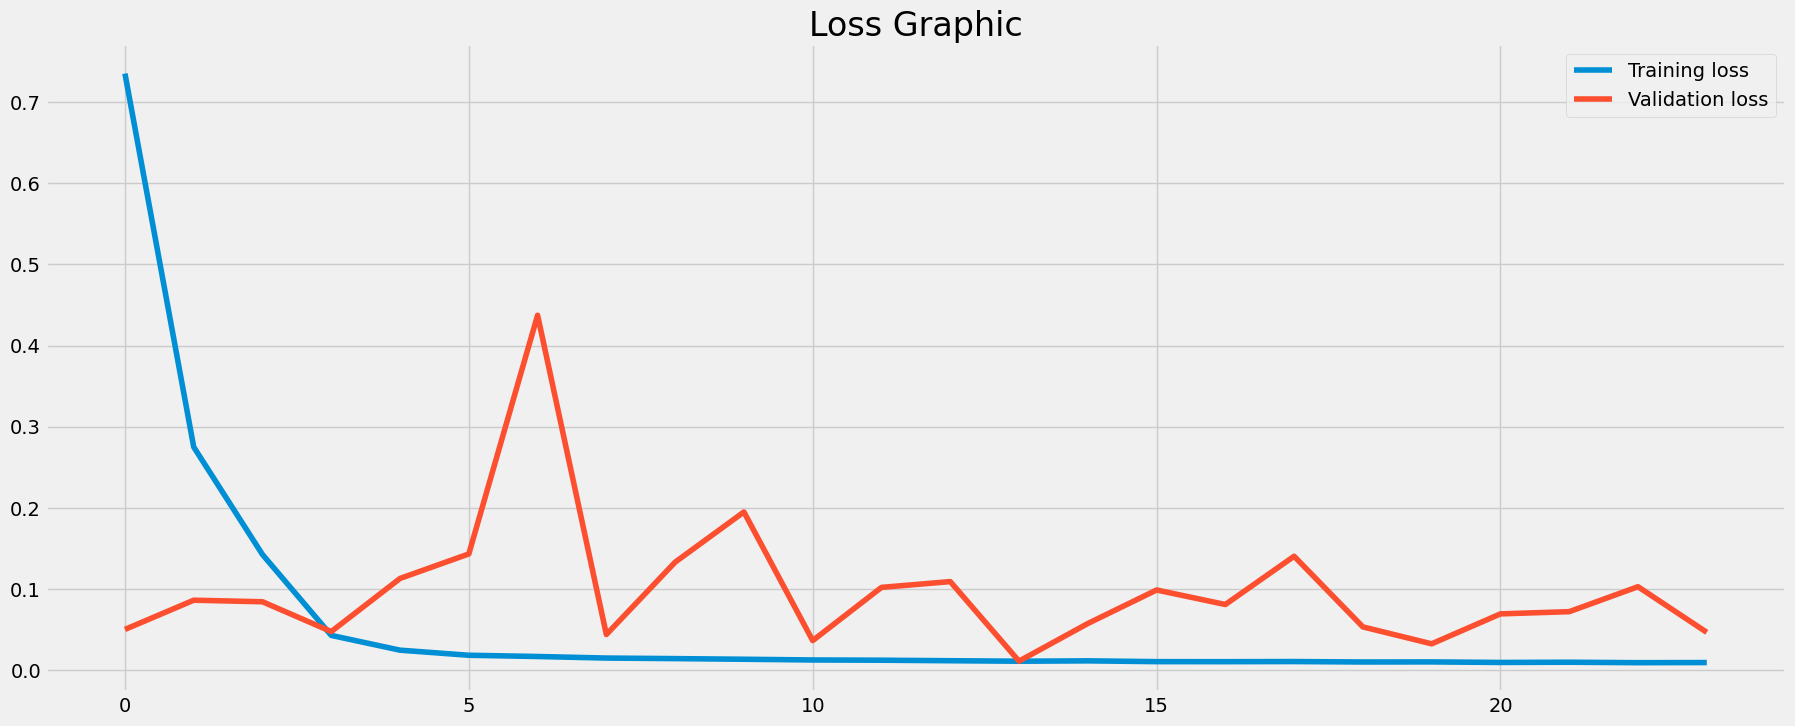

In [ ]:
plt.figure(figsize = (20, 8))
plt.plot(history_residual.history['loss'], label = 'Training loss')
plt.plot(history_residual.history['val_loss'], label = 'Validation loss')
plt.title('Loss Graphic', fontsize = 24)
plt.legend()

In [ ]:
test_predict_2 = model_residual.predict(X_test_residual)

18/18 [==============================] - 1s 2ms/step


In [ ]:
test_data_residual = np.array(testing_data_residual[5:])
test_data_residual = pd.DataFrame(test_data_residual, index=test_index, columns = ['Residual Close', 'Residual Kurs Dollar'])
test_data_residual.index.names = ['Date']
test_data_residual

Residual Close  Residual Kurs Dollar
Date                                            
2020-09-29      -37.622988             11.969458
2020-09-30       73.925049             21.166135
2020-10-01      380.969134          -1084.241151
2020-10-02      -95.471857           -390.243477
2020-10-06      -57.385179             52.809925
...                    ...                   ...
2023-06-23      103.293593            -47.199322
2023-06-26       20.225733             72.264123
2023-06-27      -74.519237             37.859885
2023-07-03        4.504500            283.357758
2023-07-06      171.490311           -382.783256

[573 rows x 2 columns]

In [ ]:
test_model_residual = scaler.inverse_transform(test_predict_2)
test_model_residual

array([[ 401.76498, -188.55336],
       [ 414.13983, -173.39146],
       [ 417.6641 , -169.04657],
       ...,
       [ 415.35117, -168.52219],
       [ 407.2204 , -175.88771],
       [ 378.8118 , -202.38736]], dtype=float32)

In [ ]:
test_model_residual = pd.DataFrame(test_model_residual, index= test_index, columns = ['Prediction Close', 'Prediction Kurs Dollar'])
test_model_residual.index.names = ['Date']
test_model_residual

Prediction Close  Prediction Kurs Dollar
Date                                                
2020-09-29        401.764984             -188.553360
2020-09-30        414.139832             -173.391464
2020-10-01        417.664093             -169.046570
2020-10-02        582.410095              -20.154694
2020-10-06        638.704956               61.041626
...                      ...                     ...
2023-06-23        402.161530             -183.935364
2023-06-26        419.165100             -166.949432
2023-06-27        415.351166             -168.522186
2023-07-03        407.220398             -175.887711
2023-07-06        378.811798             -202.387360

[573 rows x 2 columns]

### **Evaluasi Model**

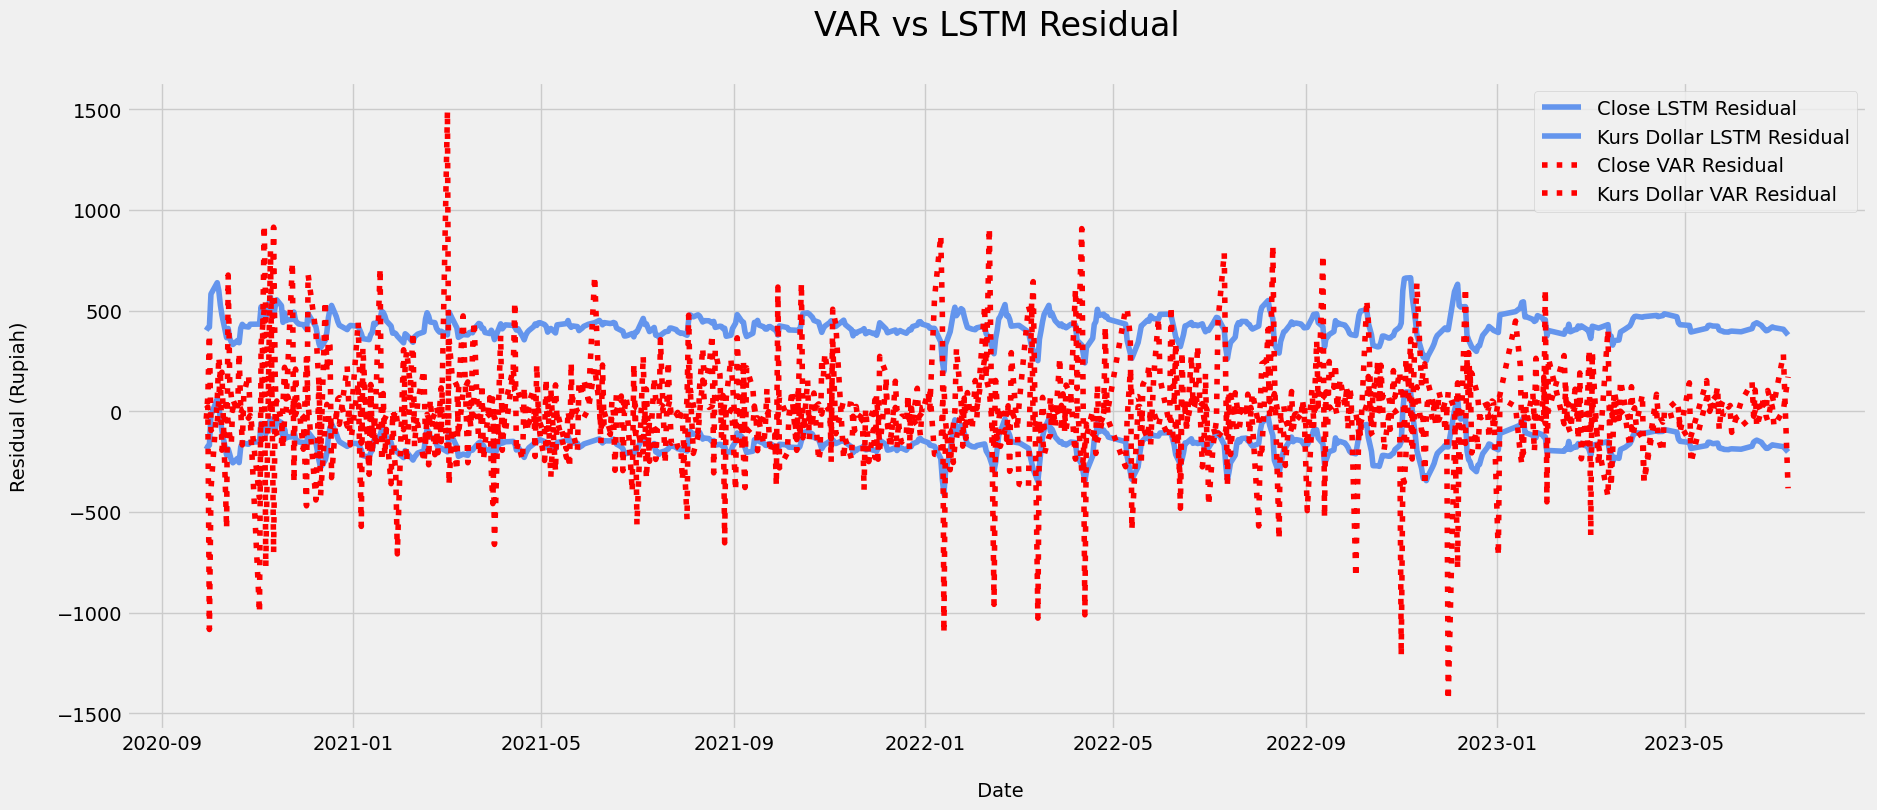

In [ ]:
plt.figure(figsize = (20, 8))
plt.plot(test_model_residual, label = ('Close LSTM Residual', 'Kurs Dollar LSTM Residual'), color = 'cornflowerblue')
plt.plot(test_data_residual, label = ('Close VAR Residual', 'Kurs Dollar VAR Residual'), linestyle = 'dotted', color='red')
plt.title('VAR vs LSTM Residual\n', fontsize = 24)
plt.xlabel('\n Date', fontsize = 14)
plt.ylabel('Residual (Rupiah)\n', fontsize = 14)
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(test_data_residual, test_model_residual)
rmse = mse**(1/2)
mape = mean_absolute_percentage_error(test_data_residual, test_model_residual)
mae = mean_absolute_error(test_data_residual, test_model_residual)
akurasi = 100 - mape
print("MSE LSTM model 2  is %.2f" % mse)
print("RMSE LSTM model 2 is %.2f" % rmse)
print("MAPE LSTM model 2 is %.2f" % mape)
print("MAE LSTM model 2 is %.2f" % mae)
print("Accuracy LSTM model 2 is %.2f" % akurasi)

MSE LSTM model 2  is 157840.14
RMSE LSTM model 2 is 397.29
MAPE LSTM model 2 is 19.29
MAE LSTM model 2 is 332.82
Accuracy LSTM model 2 is 80.71


### **Peramalan Residual**

In [ ]:
residual_scale = pd.DataFrame(scaler.fit_transform(residual), index=prediction.index,columns = ['Residual Close', 'Residual Kurs Dollar'])
residual_scale

Residual Close  Residual Kurs Dollar
Date                                            
2010-01-15        0.609342              0.519382
2010-01-18        0.578408              0.514938
2010-01-19        0.619500              0.513484
2010-01-20        0.630165              0.524328
2010-01-21        0.565372              0.522422
...                    ...                   ...
2023-06-23        0.619315              0.496320
2023-06-26        0.596538              0.519749
2023-06-27        0.570559              0.513002
2023-07-03        0.592227              0.561149
2023-07-06        0.638014              0.430505

[2888 rows x 2 columns]

In [ ]:
time_steps = 30
input_residual = residual_scale.tail(time_steps)
input_residual

Residual Close  Residual Kurs Dollar
Date                                            
2023-04-27        0.588643              0.507706
2023-04-28        0.572973              0.484299
2023-05-04        0.551102              0.533298
2023-05-05        0.557020              0.455251
2023-05-15        0.632789              0.518305
2023-05-16        0.598134              0.512628
2023-05-17        0.602125              0.505444
2023-05-19        0.588540              0.516490
2023-05-22        0.624621              0.522636
2023-05-23        0.565431              0.505617
2023-05-24        0.588427              0.508629
2023-05-25        0.582545              0.514136
2023-05-26        0.590756              0.516738
2023-05-29        0.591487              0.509629
2023-05-30        0.592404              0.511216
2023-05-31        0.562196              0.506301
2023-06-06        0.603779              0.490837
2023-06-13        0.630530              0.500162
2023-06-14        0.584314              0.501390
2023-06-15        0.619865              0.506167
2023-06-16        0.569372              0.513764
2023-06-19        0.593341              0.504623
2023-06-20        0.600291              0.516420
2023-06-21        0.593281              0.520440
2023-06-22        0.592318              0.500718
2023-06-23        0.619315              0.496320
2023-06-26        0.596538              0.519749
2023-06-27        0.570559              0.513002
2023-07-03        0.592227              0.561149
2023-07-06        0.638014              0.430505

In [ ]:
x_input_residual = np.array(input_residual).reshape(1,-1)
x_input_residual = x_input_residual.reshape((time_steps, 1, 2))
x_input_residual

array([[[0.58864311, 0.50770617]],

       [[0.57297301, 0.48429946]],

       [[0.55110209, 0.53329791]],

       [[0.55702001, 0.45525051]],

       [[0.63278858, 0.51830479]],

       [[0.59813431, 0.51262799]],

       [[0.60212511, 0.50544384]],

       [[0.58853958, 0.5164904 ]],

       [[0.62462057, 0.52263554]],

       [[0.5654311 , 0.5056169 ]],

       [[0.58842701, 0.50862879]],

       [[0.58254535, 0.51413565]],

       [[0.59075586, 0.51673819]],

       [[0.59148699, 0.5096285 ]],

       [[0.59240359, 0.51121644]],

       [[0.56219564, 0.50630142]],

       [[0.60377917, 0.49083698]],

       [[0.6305302 , 0.50016153]],

       [[0.58431363, 0.50138971]],

       [[0.61986453, 0.50616657]],

       [[0.56937194, 0.51376422]],

       [[0.59334056, 0.50462303]],

       [[0.60029079, 0.51642025]],

       [[0.59328054, 0.52044046]],

       [[0.59231808, 0.50071805]],

       [[0.61931459, 0.49631986]],

       [[0.59653763, 0.51974896]],

       [[0.57055884, 0.51300

In [ ]:
daily_input_residual = list(x_input_residual)
daily_input_residual = daily_input_residual[0].tolist()
daily_input_residual

[[0.5886431142434938, 0.5077061746216017]]

In [ ]:
yhat_residual = model_residual.predict(x_input_residual)
yhat_residual

1/1 [==============================] - 1s 556ms/step


array([[0.5784019 , 0.6302804 ],
       [0.57928807, 0.63339984],
       [0.57370436, 0.62530136],
       [0.5806295 , 0.63743985],
       [0.58050656, 0.6299536 ],
       [0.5786387 , 0.6298115 ],
       [0.5795173 , 0.6310175 ],
       [0.577659  , 0.6289463 ],
       [0.57959044, 0.6290678 ],
       [0.5769734 , 0.62991285],
       [0.57830966, 0.63013405],
       [0.57744473, 0.6291263 ],
       [0.5777899 , 0.62897396],
       [0.5784358 , 0.630072  ],
       [0.57836527, 0.62985796],
       [0.5766918 , 0.62971234],
       [0.5808719 , 0.6332947 ],
       [0.5819036 , 0.6326375 ],
       [0.5786346 , 0.6311147 ],
       [0.5806659 , 0.6314198 ],
       [0.57656884, 0.62879276],
       [0.57898414, 0.63088655],
       [0.57846713, 0.6293007 ],
       [0.5776528 , 0.628489  ],
       [0.5792434 , 0.63145137],
       [0.58146906, 0.632903  ],
       [0.5779325 , 0.6286887 ],
       [0.57671404, 0.62894356],
       [0.57422364, 0.6223885 ],
       [0.58852285, 0.64365673]], dtype=flo

### **Peramalan Data Residual**

In [ ]:
# Peramalan
from numpy import array

output_peramalan_residual = []
time_steps = 30
i = 0

#print(daily_input)
print("{} daily input {}".format(i, daily_input_residual))

#print(x_input)
print("{} daily output {}".format(i, yhat_residual))
daily_input_residual.extend(yhat_residual.tolist())
daily_input_residual = daily_input_residual[1:]

#print(daily_input)
output_peramalan_residual.extend(yhat_residual.tolist())
i = i+1

print(output_peramalan_residual)

0 daily input [[0.5886431142434938, 0.5077061746216017]]
0 daily output [[0.5784019  0.6302804 ]
 [0.57928807 0.63339984]
 [0.57370436 0.62530136]
 [0.5806295  0.63743985]
 [0.58050656 0.6299536 ]
 [0.5786387  0.6298115 ]
 [0.5795173  0.6310175 ]
 [0.577659   0.6289463 ]
 [0.57959044 0.6290678 ]
 [0.5769734  0.62991285]
 [0.57830966 0.63013405]
 [0.57744473 0.6291263 ]
 [0.5777899  0.62897396]
 [0.5784358  0.630072  ]
 [0.57836527 0.62985796]
 [0.5766918  0.62971234]
 [0.5808719  0.6332947 ]
 [0.5819036  0.6326375 ]
 [0.5786346  0.6311147 ]
 [0.5806659  0.6314198 ]
 [0.57656884 0.62879276]
 [0.57898414 0.63088655]
 [0.57846713 0.6293007 ]
 [0.5776528  0.628489  ]
 [0.5792434  0.63145137]
 [0.58146906 0.632903  ]
 [0.5779325  0.6286887 ]
 [0.57671404 0.62894356]
 [0.57422364 0.6223885 ]
 [0.58852285 0.64365673]]
[[0.5784019231796265, 0.6302803754806519], [0.5792880654335022, 0.6333998441696167], [0.5737043619155884, 0.6253013610839844], [0.5806295275688171, 0.6374398469924927], [0.58050

In [ ]:
output_forecast_residual = pd.DataFrame(output_peramalan_residual, index= data_update.index, columns = ['Forecast Residual Close', 'Forecast Residual Kurs Dollar'])
output_forecast_residual

Forecast Residual Close  Forecast Residual Kurs Dollar
Date                                                              
2023-07-07                 0.578402                       0.630280
2023-07-10                 0.579288                       0.633400
2023-07-11                 0.573704                       0.625301
2023-07-12                 0.580630                       0.637440
2023-07-13                 0.580507                       0.629954
2023-07-14                 0.578639                       0.629812
2023-07-17                 0.579517                       0.631018
2023-07-18                 0.577659                       0.628946
2023-07-20                 0.579590                       0.629068
2023-07-21                 0.576973                       0.629913
2023-07-24                 0.578310                       0.630134
2023-07-25                 0.577445                       0.629126
2023-07-26                 0.577790                       0.628974
2023-07-27                 0.578436                       0.630072
2023-07-28                 0.578365                       0.629858
2023-07-31                 0.576692                       0.629712
2023-08-01                 0.580872                       0.633295
2023-08-02                 0.581904                       0.632638
2023-08-03                 0.578635                       0.631115
2023-08-04                 0.580666                       0.631420
2023-08-07                 0.576569                       0.628793
2023-08-08                 0.578984                       0.630887
2023-08-09                 0.578467                       0.629301
2023-08-10                 0.577653                       0.628489
2023-08-11                 0.579243                       0.631451
2023-08-14                 0.581469                       0.632903
2023-08-15                 0.577932                       0.628689
2023-08-16                 0.576714                       0.628944
2023-08-18                 0.574224                       0.622388
2023-08-21                 0.588523                       0.643657

Text(0.5, 1.0, 'Forecasting Model LSTM for Residual\n')

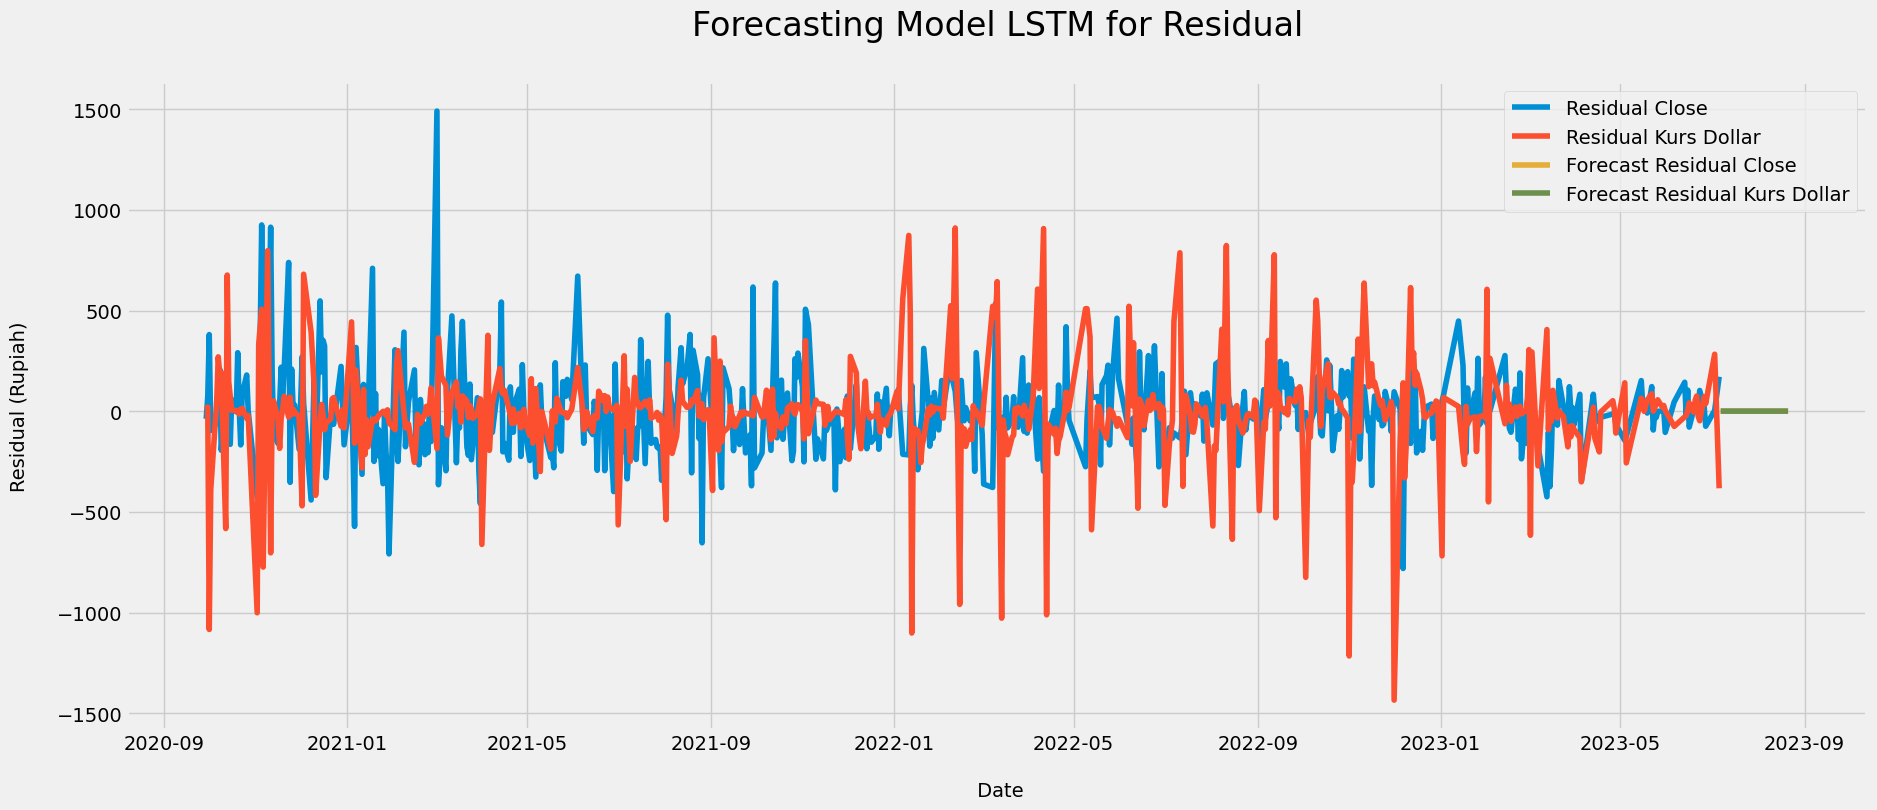

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(week_predict, residual[2315:], label = ['Residual Close', 'Residual Kurs Dollar'])
plt.plot(week_forecast , output_forecast_residual, label = ['Forecast Residual Close', 'Forecast Residual Kurs Dollar'])
plt.xlabel('\n Date', fontsize = 14)
plt.ylabel('Residual (Rupiah)\n', fontsize = 14)
plt.legend()
plt.title( 'Forecasting Model LSTM for Residual\n', fontsize = 24)

## **MODEL HYBRID**

In [ ]:
test_model_prediction = prediction[2315:]
test_model_prediction

Prediction Close  Prediction Kurs Dollar
Date                                                
2020-09-29       9124.473496            14961.022723
2020-09-30       9099.473496            14922.022723
2020-10-01       9174.473496            14920.022723
2020-10-02       9574.473496            13814.022723
2020-10-06       9449.473496            13710.022723
...                      ...                     ...
2023-06-23       6024.473496            14984.022723
2023-06-26       6124.473496            14920.022723
2023-06-27       6149.473496            15000.022723
2023-07-03       6074.473496            15028.022723
2023-07-06       6074.473496            15303.022723

[573 rows x 2 columns]

In [ ]:
test_model_prediction.index = test_model_residual.index

In [ ]:
prediction_hybrid = test_model_prediction + test_model_residual
prediction_hybrid = pd.DataFrame(prediction_hybrid)
prediction_hybrid

Prediction Close  Prediction Kurs Dollar
Date                                                
2020-09-29       9526.238480            14772.469363
2020-09-30       9513.613328            14748.631259
2020-10-01       9592.137589            14750.976153
2020-10-02      10156.883592            13793.868029
2020-10-06      10088.178452            13771.064349
...                      ...                     ...
2023-06-23       6426.635026            14800.087359
2023-06-26       6543.638596            14753.073291
2023-06-27       6564.824662            14831.500537
2023-07-03       6481.693894            14852.135012
2023-07-06       6453.285294            15100.635363

[573 rows x 2 columns]

In [ ]:
data_hybrid = data[2322:]
data_hybrid

Close  Kurs Dollar
Date                           
2020-09-29  9100.0        14920
2020-09-30  9175.0        14918
2020-10-01  9575.0        13812
2020-10-02  9450.0        13708
2020-10-06  9425.0        14083
...            ...          ...
2023-06-23  6125.0        14918
2023-06-26  6150.0        14998
2023-06-27  6075.0        15026
2023-07-03  6075.0        15301
2023-07-06  6250.0        14839

[573 rows x 2 columns]

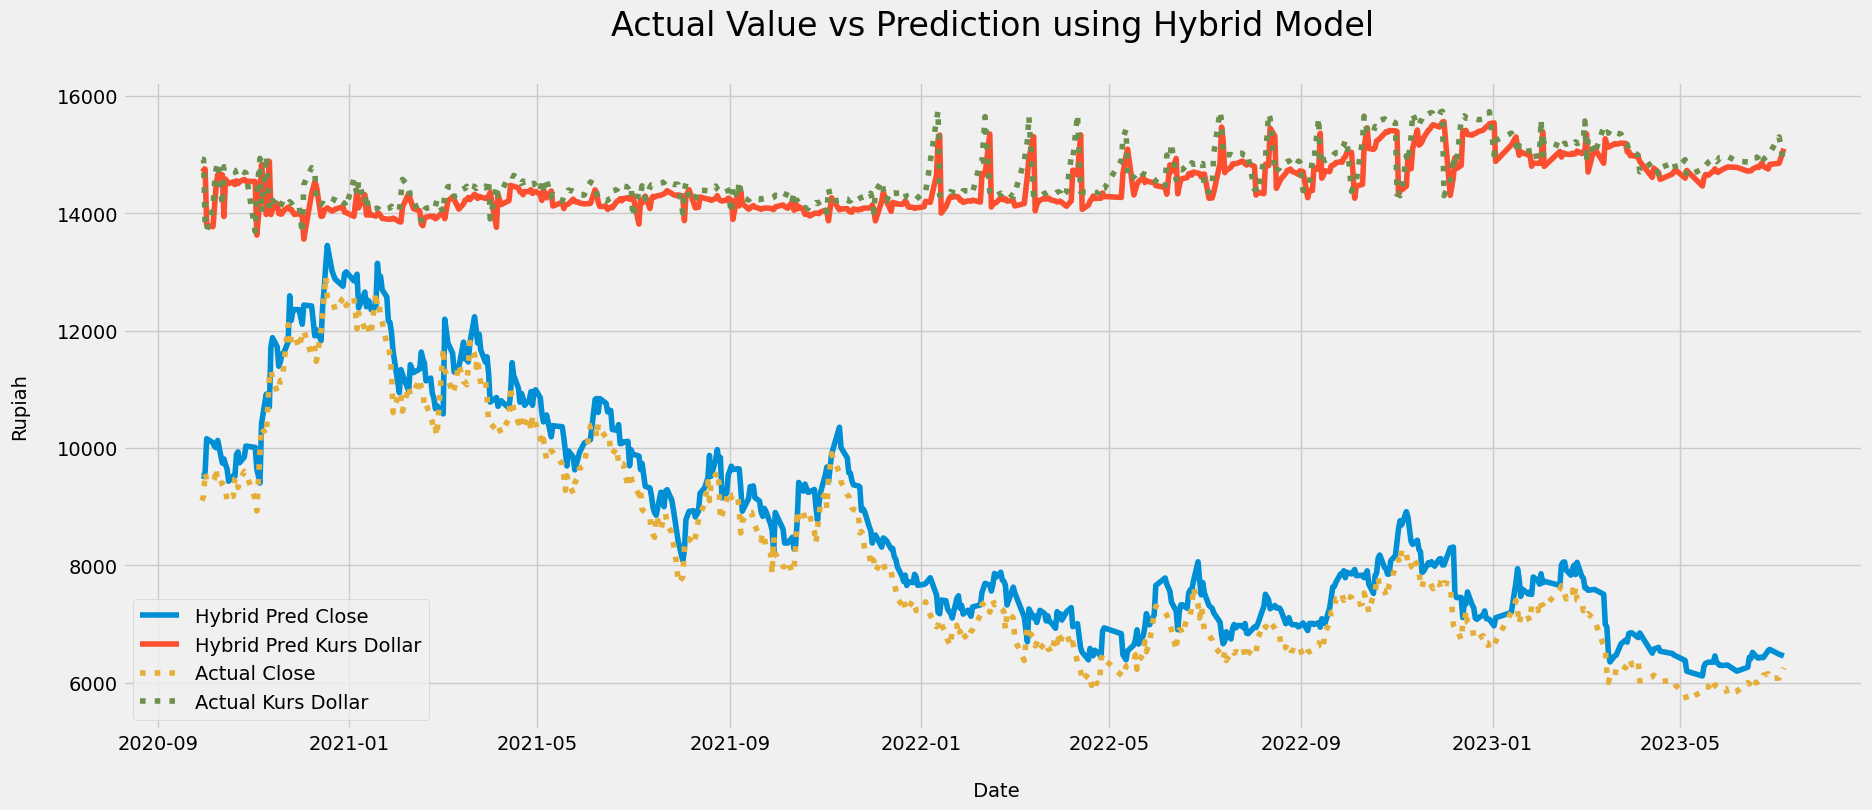

In [ ]:
plt.figure(figsize = (20,8))
plt.plot(test_index, np.array(prediction_hybrid), label = ['Hybrid Pred Close', 'Hybrid Pred Kurs Dollar'])
plt.plot(test_index, np.array(data_hybrid), label = ['Actual Close', 'Actual Kurs Dollar'], linestyle = 'dotted')
plt.title('Actual Value vs Prediction using Hybrid Model\n', fontsize = 24)
plt.xlabel('\n Date', fontsize = 14)
plt.ylabel('Rupiah\n', fontsize = 14)
plt.legend()
plt.show()

In [ ]:
mse = mean_squared_error(data_hybrid, prediction_hybrid)
rmse = mse**(1/2)
mape = mean_absolute_percentage_error(data_hybrid, prediction_hybrid)
mae = mean_absolute_error(data_hybrid, prediction_hybrid)
akurasi = 100 - mape
print("MSE LSTM model1  is %.2f" % mse)
print("RMSE LSTM model1 is %.2f" % rmse)
print("MAPE LSTM model1 is %.3f" % mape)
print("MAE LSTM model1 is %.2f" % mae)
print("Accuracy LSTM model1 is %.3f" % akurasi)

MSE LSTM model1  is 159186.89
RMSE LSTM model1 is 398.98
MAPE LSTM model1 is 0.035
MAE LSTM model1 is 334.93
Accuracy LSTM model1 is 99.965


In [ ]:
forecasting_hybrid = output_forecast_prediction['Forecast Close'] + output_forecast_residual['Forecast Residual Close']
forecasting_hybrid = pd.DataFrame(forecasting_hybrid, columns = ['Forecast Hybrid Close'])
forecasting_hybrid['Forecast Hybrid Kurs Dollar'] = output_forecast_prediction['Forecast Kurs Dollar'] + output_forecast_residual['Forecast Residual Kurs Dollar']
forecasting_hybrid

Forecast Hybrid Close  Forecast Hybrid Kurs Dollar
Date                                                          
2023-07-07            7105.922360                 14712.896305
2023-07-10            7106.559718                 14728.602371
2023-07-11            7067.545195                 14659.935958
2023-07-12            7001.121548                 14771.342080
2023-07-13            6952.991000                 14618.984319
2023-07-14            7021.048788                 14672.355638
2023-07-17            7045.217094                 14701.853548
2023-07-18            7056.901141                 14697.800615
2023-07-20            7058.221798                 14735.599558
2023-07-21            7120.226155                 14756.978109
2023-07-24            7070.575794                 14745.467903
2023-07-25            7058.281982                 14737.327167
2023-07-26            7047.059482                 14755.577360
2023-07-27            7048.040848                 14782.180772
2023-07-28            7048.189813                 14786.111971
2023-07-31            7048.488292                 14793.949479
2023-08-01            7002.149679                 14802.665349
2023-08-02            7023.483095                 14751.496599
2023-08-03            7094.162070                 14726.702248
2023-08-04            7081.934276                 14725.986853
2023-08-07            7131.644997                 14730.727095
2023-08-08            7095.778622                 14766.291571
2023-08-09            7095.826363                 14767.425726
2023-08-10            7109.312564                 14792.430972
2023-08-11            7110.500096                 14818.050064
2023-08-14            7109.012363                 14785.695468
2023-08-15            7157.496382                 14738.734931
2023-08-16            7172.590354                 14781.873127
2023-08-18            7135.104655                 14805.172225
2023-08-21            7143.216415                 14952.428735

##**DATA UPDATE**

In [ ]:
dataset_update = pd.read_excel("/content/drive/MyDrive/SATRIADATA2023/SEC/Data Update (1).xlsx", parse_dates = True, index_col = 0)
dataset_update

Close  Kurs Dollar
Date                          
2023-07-07   6425        15062
2023-07-10   6425        15136
2023-07-11   6550        15192
2023-07-12   6500        15162
2023-07-13   6725        15084
2023-07-14   6875        14978
2023-07-17   6775        14945
2023-07-18   6775        15007
2023-07-20   6700        14994
2023-07-21   6950        14991
2023-07-24   6950        15026
2023-07-25   7000        15028
2023-07-26   6825        15007
2023-07-27   6675        15032
2023-07-28   6750        15003
2023-07-31   6975        15083
2023-08-01   6725        15092
2023-08-02   6825        15117
2023-08-03   7225        15171
2023-08-04   7075        15198
2023-08-07   6950        15168
2023-08-08   6850        15178
2023-08-09   6675        15229
2023-08-10   6650        15206
2023-08-11   6725        15204
2023-08-14   6850        15225
2023-08-15   6850        15323
2023-08-16   6925        15346
2023-08-18   6725        15308
2023-08-21   6700        15308
2023-08-22   6750        15329
2023-08-23   6725        15326
2023-08-24   6875        15319
2023-08-25   6875        15253

In [ ]:
data_update = dataset_update[['Close', 'Kurs Dollar']]
data_update = data_update[0:30]
data_update

Close  Kurs Dollar
Date                          
2023-07-07   6425        15062
2023-07-10   6425        15136
2023-07-11   6550        15192
2023-07-12   6500        15162
2023-07-13   6725        15084
2023-07-14   6875        14978
2023-07-17   6775        14945
2023-07-18   6775        15007
2023-07-20   6700        14994
2023-07-21   6950        14991
2023-07-24   6950        15026
2023-07-25   7000        15028
2023-07-26   6825        15007
2023-07-27   6675        15032
2023-07-28   6750        15003
2023-07-31   6975        15083
2023-08-01   6725        15092
2023-08-02   6825        15117
2023-08-03   7225        15171
2023-08-04   7075        15198
2023-08-07   6950        15168
2023-08-08   6850        15178
2023-08-09   6675        15229
2023-08-10   6650        15206
2023-08-11   6725        15204
2023-08-14   6850        15225
2023-08-15   6850        15323
2023-08-16   6925        15346
2023-08-18   6725        15308
2023-08-21   6700        15308

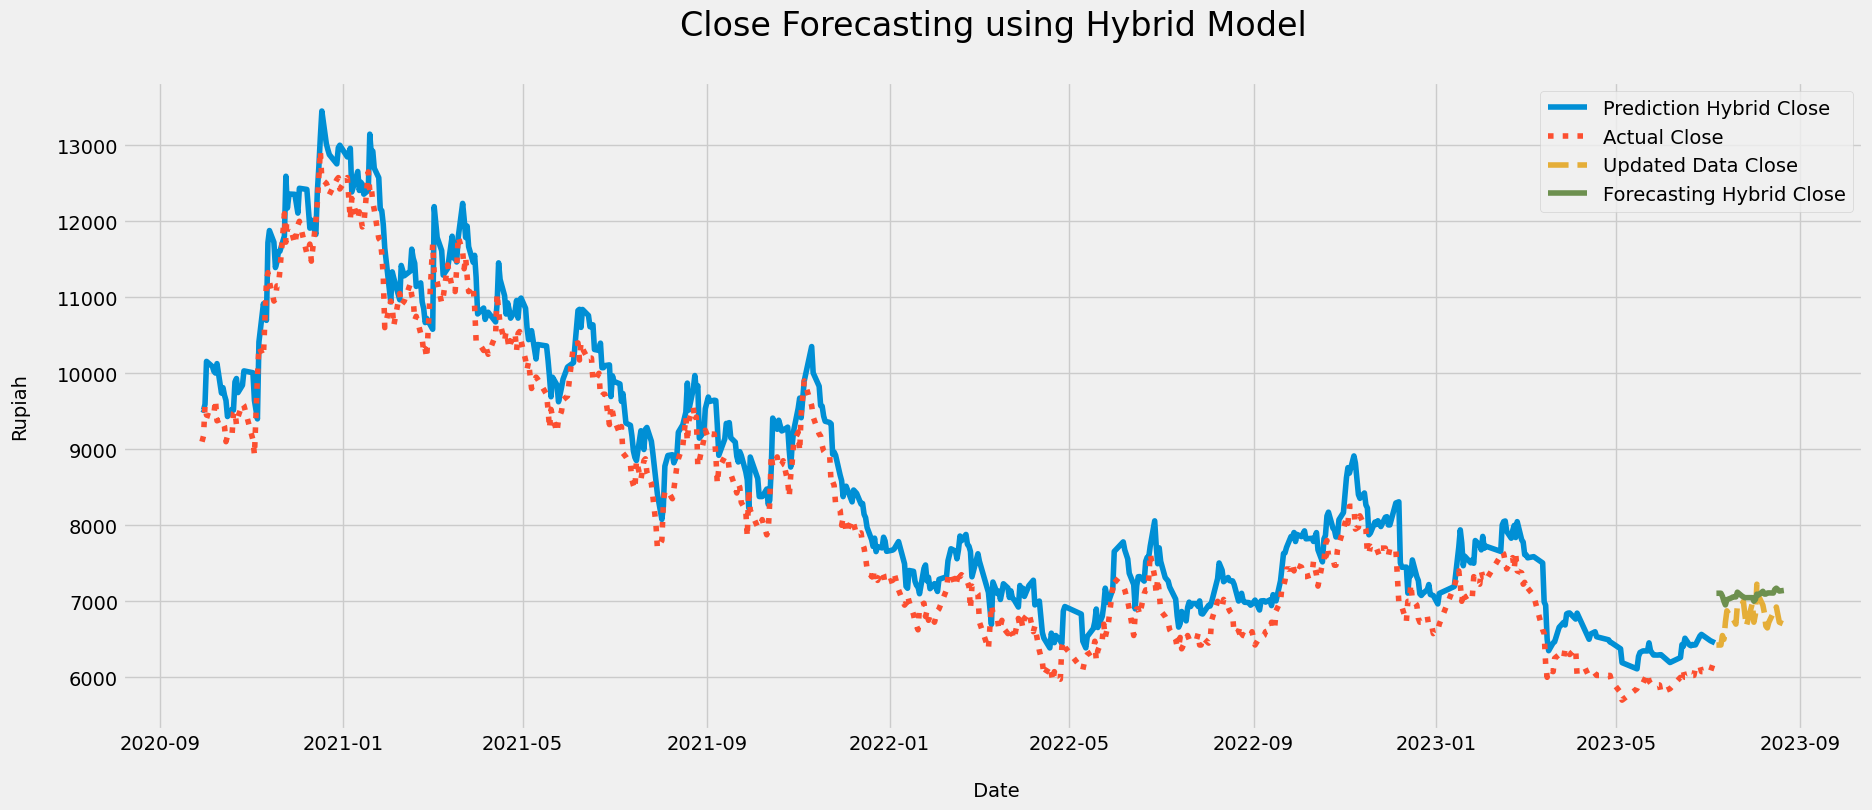

In [ ]:
#Close
plt.figure(figsize = (20,8))
plt.plot(test_index, np.array(prediction_hybrid['Prediction Close']), label = "Prediction Hybrid Close")
plt.plot(test_index, np.array(data_hybrid['Close']), label = "Actual Close", linestyle = 'dotted')
plt.plot(data_update.index , data_update['Close'], label = 'Updated Data Close', linestyle = 'dashed')
plt.plot(data_update.index, forecasting_hybrid['Forecast Hybrid Close'], label = 'Forecasting Hybrid Close')
plt.title('Close Forecasting using Hybrid Model\n', fontsize = 24)
plt.xlabel('\n Date', fontsize = 14)
plt.ylabel('Rupiah\n', fontsize = 14)
plt.legend()
plt.show()

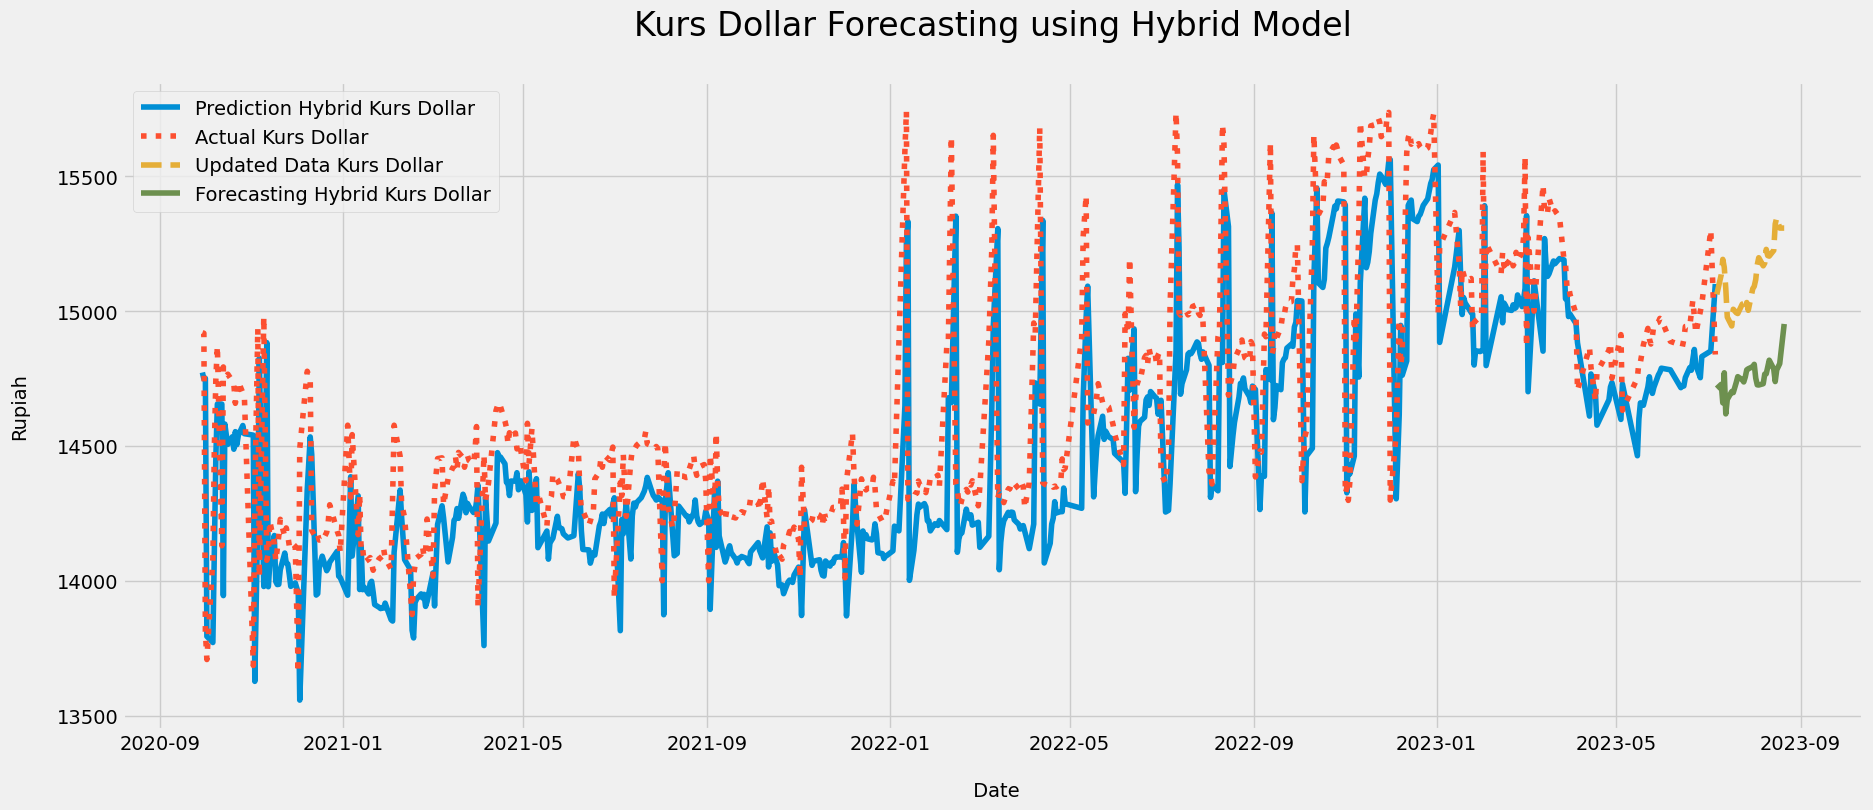

In [ ]:
#Close
plt.figure(figsize = (20,8))
plt.plot(test_index, np.array(prediction_hybrid['Prediction Kurs Dollar']), label = "Prediction Hybrid Kurs Dollar")
plt.plot(test_index, np.array(data_hybrid['Kurs Dollar']), label = "Actual Kurs Dollar", linestyle = 'dotted')
plt.plot(data_update.index, data_update['Kurs Dollar'], label = 'Updated Data Kurs Dollar', linestyle = 'dashed')
plt.plot(data_update.index, forecasting_hybrid['Forecast Hybrid Kurs Dollar'], label = 'Forecasting Hybrid Kurs Dollar')
plt.title('Kurs Dollar Forecasting using Hybrid Model\n', fontsize = 24)
plt.xlabel('\n Date', fontsize = 14)
plt.ylabel('Rupiah\n', fontsize = 14)
plt.legend()
plt.show()

In [ ]:
# Accuracy Prediction Hybrid
mse = mean_squared_error(data_update, forecasting_hybrid)
rmse = mse**(1/2)
mape = mean_absolute_percentage_error(data_update,forecasting_hybrid)
mae = mean_absolute_error(data_update,forecasting_hybrid)
akurasi = 100 - mape
print("MSE Hybrid model 2  is %.2f" % mse)
print("RMSE Hybrid model 2 is %.2f" % rmse)
print("MAPE Hybrid model 2 is %.2f" % mape)
print("MAE Hybrid model 2 is %.2f" % mae)
print("Accuracy Hybrid model 2 is %.2f" % akurasi)

MSE Hybrid model 2  is 132899.81
RMSE Hybrid model 2 is 364.55
MAPE Hybrid model 2 is 0.03
MAE Hybrid model 2 is 335.93
Accuracy Hybrid model 2 is 99.97
